<a href="https://colab.research.google.com/github/nadia-maarfavi/Projects/blob/master/Metadata/DataSetAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
pip install shap

     |████████████████████████████████| 358kB 6.4MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491621 sha256=00cf068a8b7c2b6d7e6f0bd5387596341a0f5583eb2262361d62c5e690cea688
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [2]:
import pandas as pd
import numpy as np
from numpy import mean
import time
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import re
from scipy.stats import pearsonr
import math
from statistics import median
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, accuracy_score
import shap
plt.style.use('ggplot')
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
def con(onecol):
  return (onecol.split(','))

In [166]:
#Load in the data
train = pd.read_csv("/content/drive/MyDrive/DataAnalysis/FullDatasetWithLabelStarsIDate.csv")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Movie                1449 non-null   object 
 1   Movie_Link           1449 non-null   object 
 2   TrailerPublishDate   1449 non-null   object 
 3   Budget               1449 non-null   int64  
 4   Language             1449 non-null   object 
 5   Time_minute          1449 non-null   int64  
 6   Genres               1449 non-null   object 
 7   FirstGenre           1449 non-null   object 
 8   MPAA                 1449 non-null   object 
 9   MovieDirectors       1449 non-null   object 
 10  DirectorID           1449 non-null   int64  
 11  Movie_Stars          1449 non-null   object 
 12  StarsID1             1449 non-null   int64  
 13  StarsID2             1449 non-null   int64  
 14  StarsID3             1449 non-null   int64  
 15  StarsID4             1449 non-null   i

In [7]:
train.isna().sum()

Movie                   0
Movie_Link              0
TrailerPublishDate      0
Budget                  0
Language                0
Time_minute             0
Genres                  0
FirstGenre              0
MPAA                    0
MovieDirectors          0
DirectorID              0
Movie_Stars             0
StarsID1                0
StarsID2                0
StarsID3                0
StarsID4                0
Description             0
Countries               0
Follows                 0
ProductionCompanies    19
ReleaseDate             0
mean                    0
median                  0
std                     0
total                   0
Label                   0
dtype: int64

In [8]:
print ('The train data has {} rows and {} columns'.format(train.shape[0],train.shape[1]))

The train data has 1449 rows and 26 columns


In [14]:
train_features = []
log_features = []
cols_to_drop = []

# ***Movie Name***

In [9]:
print('Movies missing a title:',train.Movie.isna().sum())
train['title_len'] = train.Movie.apply(lambda x: len(str(x)))

Movies missing a title: 0


We will just be looking at the length of the title, to see if this has any effect on a film's draw. Possibly shorter titles are easier to remember, making them perfrom better, or there is a chance that longer titles are more unique and compelling, making them pull more people in. Let's take a look at the data and see.

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


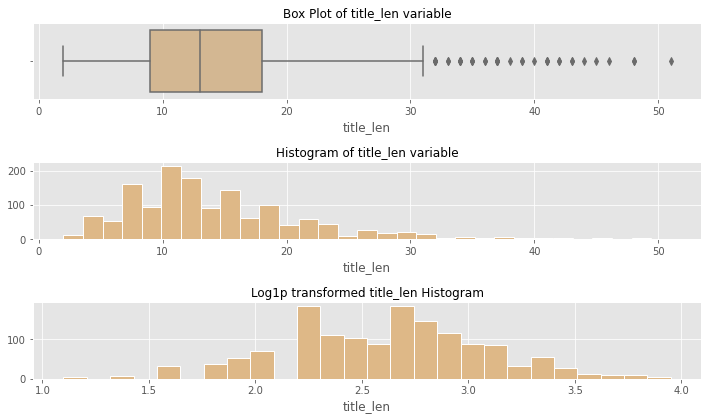

In [10]:
f, ax = plt.subplots(3, figsize=(10,6))

sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x=train.title_len, ax = ax[0], color='burlywood')
ax[0].set_title("Box Plot of title_len variable")
sns.distplot(a=train.title_len, kde = False, ax = ax[1], color='burlywood', hist_kws=dict(alpha=1))
ax[1].set_title("Histogram of title_len variable")
sns.distplot(a=np.log1p(train.title_len), kde = False, ax = ax[2], color='burlywood', hist_kws=dict(alpha=1))
ax[2].set_title("Log1p transformed title_len Histogram")
f.tight_layout()

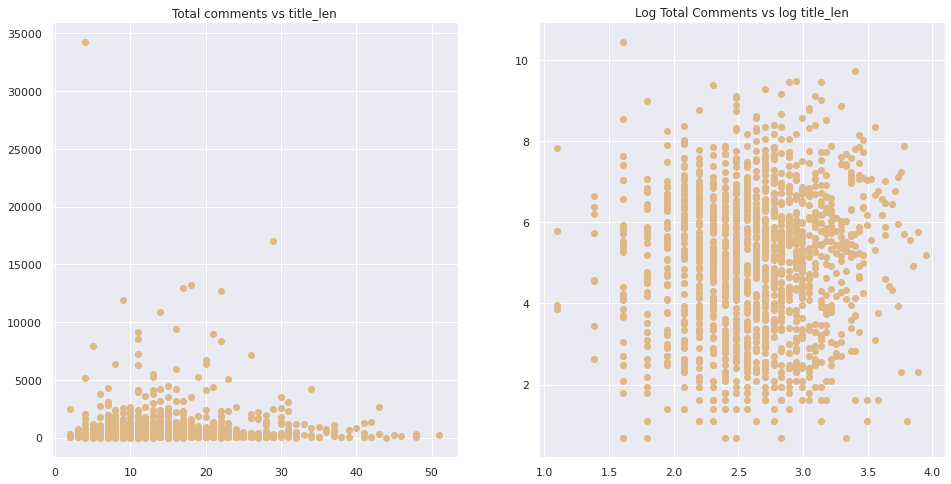

In [11]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['title_len'], train['total'], color='burlywood')
plt.title('Total comments vs title_len');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['title_len']), np.log1p(train['total']), color='burlywood')
plt.title('Log Total Comments vs log title_len');

In [12]:

# calculate Pearson's correlation with total comments
corr, _ = pearsonr(train['title_len'], train['total'])
print('Pearsons correlation between title_len and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['title_len']), np.log1p(train['total']))
print('Pearsons correlation between log transformed title_len and log transformed total comments: %.3f' % corr)

Pearsons correlation between title_len and revenue: 0.032
Pearsons correlation between log transformed title_len and log transformed total comments: 0.052


In [15]:
log_features.append('title_len')

# ***Target Variable: Total Comments***

In [16]:
print('Movies missing total comments:',train.total.isna().sum())

Movies missing total comments: 0


In [17]:
print("Mean total comments: %.2f" % train.total.mean())
print("Median total comments: %.2f" % train.total.median())

Mean total comments: 586.11
Median total comments: 190.00


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


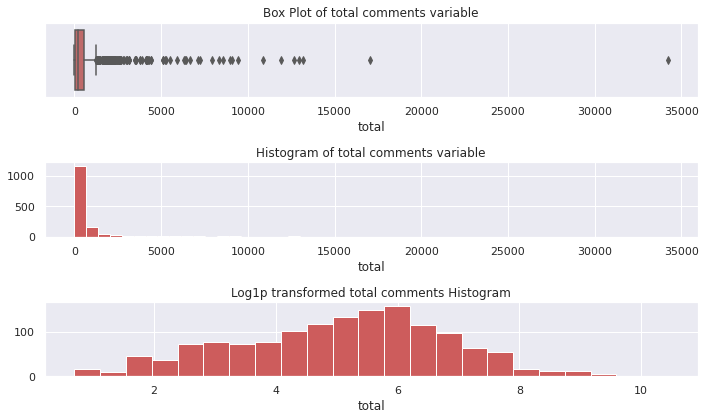

In [18]:
f, ax = plt.subplots(3, figsize=(10,6))

sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x=train.total, ax = ax[0], color='indianred')
ax[0].set_title("Box Plot of total comments variable")
sns.distplot(a=train.total, kde = False, ax = ax[1], color='indianred', hist_kws=dict(alpha=1))
ax[1].set_title("Histogram of total comments variable")
sns.distplot(a=np.log1p(train.total), kde = False, ax = ax[2], color='indianred', hist_kws=dict(alpha=1))
ax[2].set_title("Log1p transformed total comments Histogram")
f.tight_layout()

In [19]:
train['log_total'] = np.log1p(train['total'])

In [20]:
log_features.append("total")

# ***Sequel Info***

In [21]:
print(train.Follows.value_counts())

0     1302
1       78
2       20
3       13
4       11
5        7
8        5
7        4
6        4
23       1
18       1
15       1
11       1
9        1
Name: Follows, dtype: int64


In [22]:
train['Follows'] = train.Follows.apply(lambda x: 1 if x >= 1 else 0)
train['Follows'].value_counts()

0    1302
1     147
Name: Follows, dtype: int64

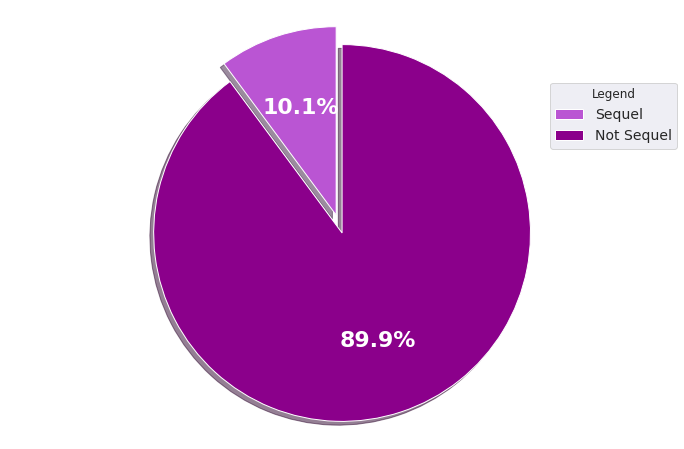

In [23]:
# plotting belongs to collection data
labels = 'Sequel', 'Not Sequel'
btc_1 = [sum(train.Follows), (train.Follows == 0).sum(axis=0)]
explode = (0.1, 0)

colors = ['mediumorchid', 'darkmagenta']

# plot
fig, ax = plt.subplots()
ax.pie(btc_1, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors, textprops={'color':"w", 'fontsize': 22, 'weight':"bold"})
ax.axis('equal') # ensures chart is a circle

ax.legend(labels,
          title="Legend",
          loc="center left",
          fontsize=14,
          bbox_to_anchor=(0.8, 0.25, 0.5, 1))

Not in Collection        1302
Belongs in Collection     147
Name: has_collection, dtype: int64


Text(0.5, 0, 'Collection Status')

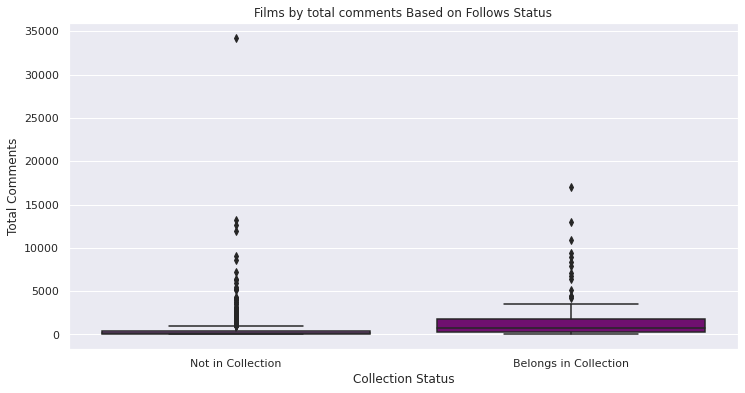

In [24]:
# bivariate analysis of revenue with belongs_to_collection
train['has_collection'] = train['Follows'].apply(lambda x: 'Belongs in Collection' if x == 1 else 'Not in Collection')
print(train['has_collection'].value_counts())

pal1 = ['mediumorchid', 'purple']

sns.set(rc={'figure.figsize':(12, 6)})
sns.boxplot(x='has_collection', y='total', data=train, palette=pal1)
plt.title('Films by total comments Based on Follows Status')
plt.ylabel("Total Comments")
plt.xlabel("Collection Status")

In [26]:
#analysis of correlation and create log feature
corr, _ = pearsonr(train['Follows'], train['total'])
print('Pearsons correlation between Sequel and total Comments: %.3f' % corr)
corr, _ = pearsonr(train['Follows'], np.log1p(train['total']))
print('Pearsons correlation between Sequel and the log total Comments: %.3f' % corr)

Pearsons correlation between Sequel and total Comments: 0.221
Pearsons correlation between Sequel and the log total Comments: 0.281


In [27]:
train_features.append('Follows')

# ***Budget***

In [28]:
print('Movies missing a budget:',train.Budget.isna().sum())


Movies missing a budget: 0


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


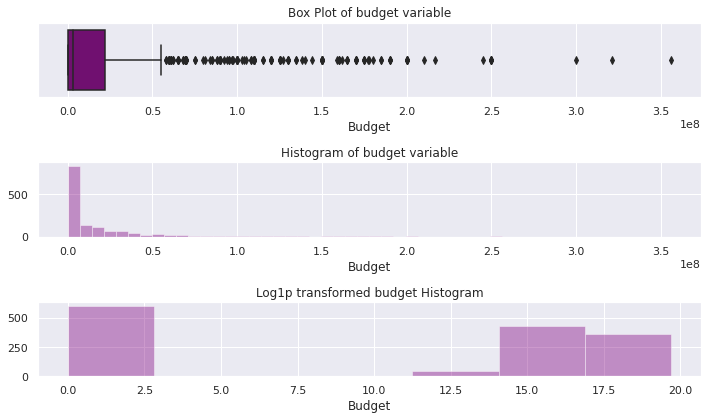

In [29]:
#plotting the data
f, ax = plt.subplots(3, figsize=(10,6))

sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x=train.Budget, ax = ax[0], color='purple')
ax[0].set_title("Box Plot of budget variable")
sns.distplot(a=train.Budget, kde = False, ax = ax[1], color='purple')
ax[1].set_title("Histogram of budget variable")
sns.distplot(a=np.log1p(train.Budget), kde = False, ax = ax[2], color='purple')
ax[2].set_title("Log1p transformed budget Histogram")
f.tight_layout()

In [30]:
print('Movies with budget listed as 0: ',(train.Budget == 0).sum())

Movies with budget listed as 0:  605


while there are no movies missing a budget, there are over 600 movies in our training set that have a budget of 0. This is highly unlikely to be accurate as every produced film has some kind of budget, so it is likely that the films where the budget was not found were replaced with 0. To clean up this data, we will replace these 0 values with the median budget to reduce the skew.

In [32]:
median = train.loc[train['Budget']> 0, 'Budget'].median()
train["budget_processed"] = train["Budget"].mask(train["Budget"] == 0, median)


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


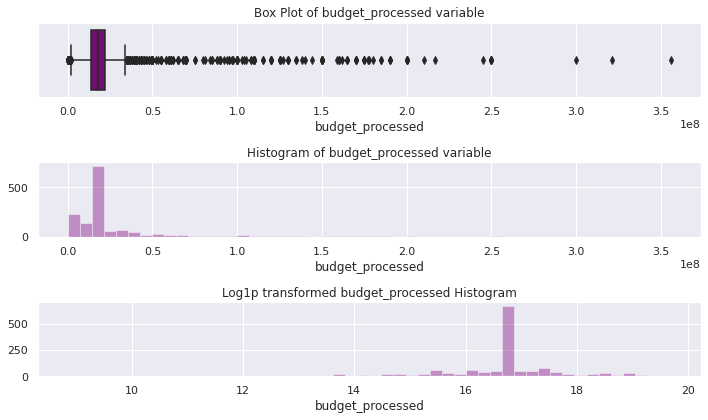

In [33]:
#plotting the data
f, ax = plt.subplots(3, figsize=(10,6))

sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x=train.budget_processed, ax = ax[0], color='purple')
ax[0].set_title("Box Plot of budget_processed variable")
sns.distplot(a=train.budget_processed, kde = False, ax = ax[1], color='purple')
ax[1].set_title("Histogram of budget_processed variable")
sns.distplot(a=np.log1p(train.budget_processed), kde = False, ax = ax[2], color='purple')
ax[2].set_title("Log1p transformed budget_processed Histogram")
f.tight_layout()

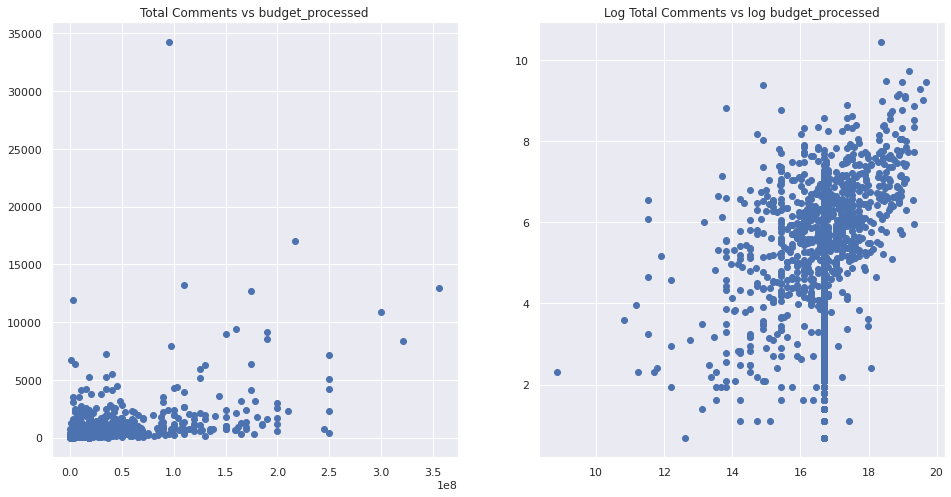

In [34]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['budget_processed'], train['total'])
plt.title('Total Comments vs budget_processed');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['budget_processed']), np.log1p(train['total']))
plt.title('Log Total Comments vs log budget_processed');

In [37]:
#analysis of correlation and create log feature probably
corr, _ = pearsonr(train['budget_processed'], train['total'])
print('Pearsons correlation between budget_processed and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['budget_processed']), np.log1p(train['total']))
print('Pearsons correlation between log budget_processed and log revenue: %.3f' % corr)

Pearsons correlation between budget_processed and revenue: 0.478
Pearsons correlation between log budget_processed and log revenue: 0.347


In [38]:
log_features.append('budget_processed')

# **Genres**

In [39]:
train['Genres'].head()

0    Biography,Drama,History
1        Crime,Drama,Mystery
2     Action,Adventure,Crime
3                     Horror
4            Horror,Thriller
Name: Genres, dtype: object

In [40]:
def extract_data(column_name):
    #df['cast']=df['cast'].astype(str)
    #df['director']=df['director'].astype(str)
    
    # From the column entered, eparate the string by '|'
    all_data = train[column_name].str.cat(sep = ',')
    
    # StorE the values separately as series
    all_data = pd.Series(all_data.split(','))
    
    # Read the descending order, starts with highest number
    count = all_data.value_counts(ascending = False)
    
    return count

In [41]:
genres_count = extract_data('Genres')
genres_count = pd.DataFrame(data=genres_count)

top_genres = genres_count.head(10)
top_genres

,0
Drama,794
Comedy,464
Action,354
Thriller,272
Crime,259
Horror,210
Romance,196
Adventure,171
Biography,161
Mystery,147


In [42]:
train['genres_reform']= train['Genres'].apply(con)

In [44]:
df = train.copy(deep=True)

In [45]:
def unpackCol(list, df):
    for i in range(len(df)):
        for name in list[i]:
            if name not in df.columns:
                df[name] = 0
            df[name][i] = 1
    return df

In [46]:
# example of using it to unpack the genres 
train = unpackCol(train['genres_reform'], train)

# here's what it did
print(train.columns)
print()


Index(['Movie', 'Movie_Link', 'TrailerPublishDate', 'Budget', 'Language',
       'Time_minute', 'Genres', 'FirstGenre', 'MPAA', 'MovieDirectors',
       'DirectorID', 'Movie_Stars', 'StarsID1', 'StarsID2', 'StarsID3',
       'StarsID4', 'Description', 'Countries', 'Follows',
       'ProductionCompanies', 'ReleaseDate', 'mean', 'median', 'std', 'total',
       'Label', 'title_len', 'log_total', 'has_collection', 'budget_processed',
       'genres_reform', 'Biography', 'Drama', 'History', 'Crime', 'Mystery',
       'Action', 'Adventure', 'Horror', 'Thriller', 'Sci-Fi', 'Comedy',
       'Animation', 'Documentary', 'Romance', 'Family', 'Musical', 'Sport',
       'Fantasy', 'Western', 'War', 'News'],
      dtype='object')



In [47]:
print(train['Drama'])
print()
print('Total number of Dramas: ', sum(train['Drama']))

0       1
1       1
2       0
3       0
4       0
       ..
1444    0
1445    1
1446    0
1447    1
1448    0
Name: Drama, Length: 1449, dtype: int64

Total number of Dramas:  794


In [48]:
# new feature for a count of the number of genres, how many genres each movie has
train['num_genres'] = train.genres_reform.apply(lambda x: len(x))
train['num_genres'].value_counts()

3    850
2    395
1    204
Name: num_genres, dtype: int64

Text(0.5, 0, 'Genre')

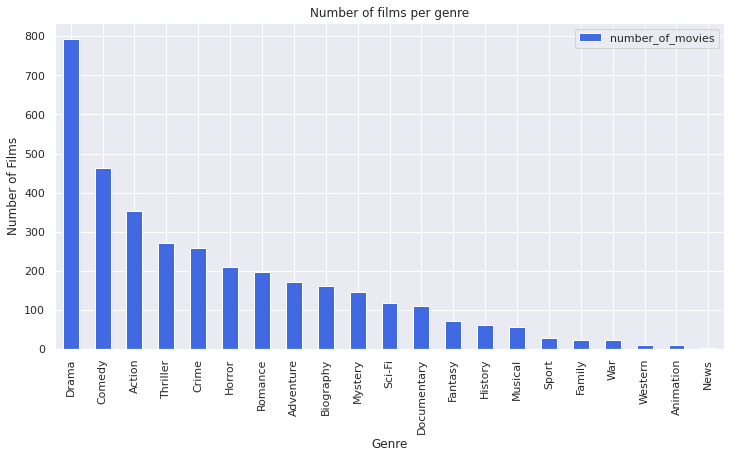

In [50]:
# plotting genres in order of number of instances in the df.csv dataset
genresDict = dict()

for genre in train["genres_reform"]:
    for elem in genre:
        if elem not in genresDict:
            genresDict[elem] = 1
        else:
            genresDict[elem] += 1


sns.set(rc={'figure.figsize':(12,6)})
genres_df = pd.DataFrame.from_dict(genresDict, orient='index')
genres_df.columns = ["number_of_movies"]
genres_df = genres_df.sort_values(by="number_of_movies", ascending=False)
genres_df.plot.bar(color='royalblue')
plt.title("Number of films per genre")
plt.ylabel("Number of Films")
plt.xlabel("Genre")

In [52]:
# list of film genres by order of number of films in set
print(train['Drama'].sum())
print(train['Comedy'].sum())
print(train['Action'].sum())
print(train['Thriller'].sum())
print(train['Crime'].sum())
print(train['Horror'].sum())
print(train['Romance'].sum())
print(train['Adventure'].sum())
print(train['Biography'].sum())
print(train['Mystery'].sum())
print(train['Sci-Fi'].sum())
print(train['Documentary'].sum())
print(train['Fantasy'].sum())
print(train['History'].sum())
print(train['Musical'].sum())
print(train['Sport'].sum())
print(train['Family'].sum())
print(train['War'].sum())
print(train['Western'].sum())
print(train['Animation'].sum())
print(train['News'].sum())

794
464
354
272
259
210
196
171
161
147
117
110
71
61
55
29
24
23
11
10
4


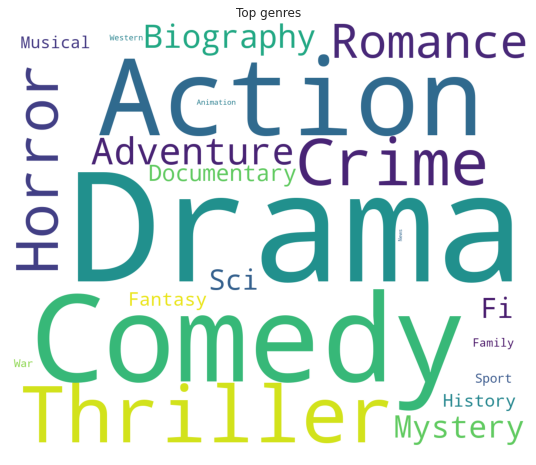

In [53]:
from wordcloud import WordCloud
plt.figure(figsize = (12, 8))
text = ' '.join([i for j in train["genres_reform"] for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top genres')
plt.axis("off")
plt.show()

In [54]:
# bivariate analysis of total comments with genre
# creating a callable index for genres
genres_df.index.values
print(genres_df.index.values)
for g in genres_df.index.values:
    train[g] = train['genres_reform'].apply(lambda x: 1 if g in x else 0)

# median total comments per genre type
for i, g in enumerate(genres_df.index.values):
    genres_df.loc[g, "median_comm"] = train[train[g]==1].total.median()
    
genres_df.sort_values(by=["number_of_movies", "median_comm"], ascending=False).head(10)

# mean revenue for genre type
for i, g in enumerate(genres_df.index.values):
    genres_df.loc[g, "mean_comm"] = train[train[g]==1].total.mean()

genres_df.sort_values(by=["number_of_movies", "mean_comm"], ascending=False).head(10)

['Drama' 'Comedy' 'Action' 'Thriller' 'Crime' 'Horror' 'Romance'
 'Adventure' 'Biography' 'Mystery' 'Sci-Fi' 'Documentary' 'Fantasy'
 'History' 'Musical' 'Sport' 'Family' 'War' 'Western' 'Animation' 'News']


,number_of_movies,median_comm,mean_comm
Drama,794,177.0,471.880353
Comedy,464,175.0,489.118534
Action,354,447.5,1170.505650
Thriller,272,234.5,603.477941
Crime,259,220.0,515.737452
Horror,210,172.0,664.509524
Romance,196,182.5,430.362245
Adventure,171,681.0,1592.596491
Biography,161,233.0,426.527950
Mystery,147,246.0,536.925170


Text(0.5, 0, 'Genre')

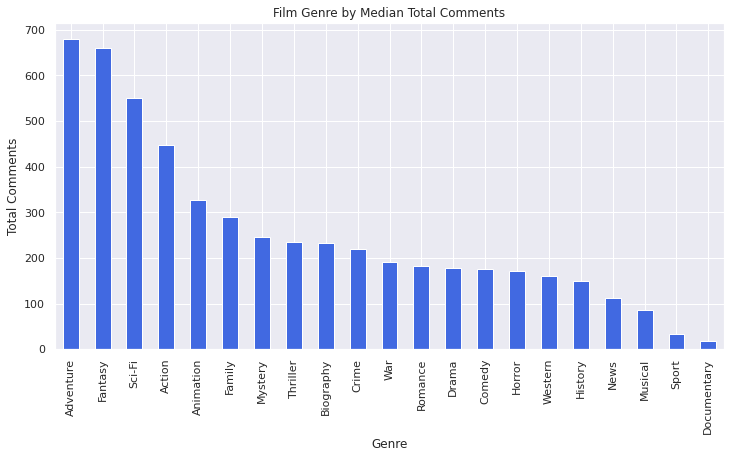

In [55]:
# genres by median total comments
genres_df.sort_values(by=["median_comm"], ascending=False).median_comm.plot.bar(color='royalblue')
plt.title("Film Genre by Median Total Comments")
plt.ylabel("Total Comments")
plt.xlabel("Genre")

Text(0.5, 0, 'Genre')

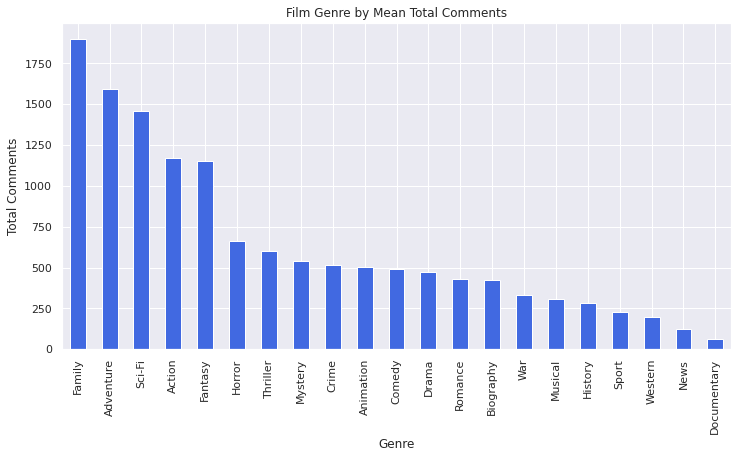

In [56]:
# genres by mean total comments
genres_df.sort_values(by=["mean_comm"], ascending=False).mean_comm.plot.bar(color='royalblue')
plt.title("Film Genre by Mean Total Comments")
plt.ylabel("Total Comments")
plt.xlabel("Genre")

{'Biography': 466.02479338842977, 'Crime': 322.0595238095238, 'Action': 1180.7057142857143, 'Horror': 739.4666666666667, 'Drama': 303.735632183908, 'Comedy': 469.3380281690141, 'Animation': 504.9, 'Thriller': 313.5, 'Documentary': 64.7, 'Mystery': 173.66666666666666, 'Adventure': 549.081081081081, 'Romance': 183.0, 'Fantasy': 359.22222222222223, 'Family': 175.5, 'Sci-Fi': 12.333333333333334, 'Western': 11.5}


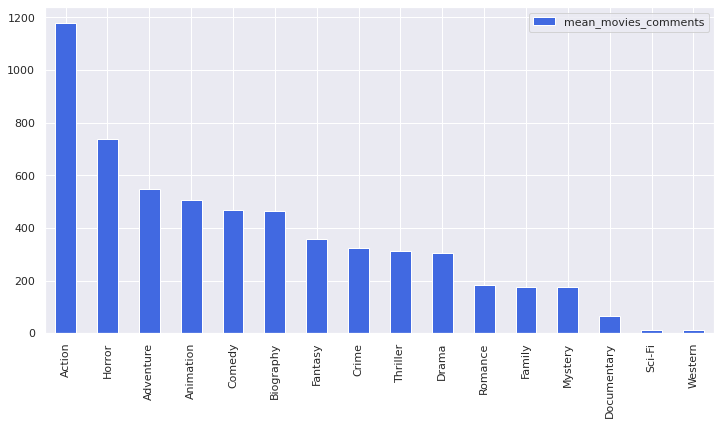

In [57]:
#Extract top genre from each movie genres, find total comments, then divide total comments by number of movie, to find the average of number of comments per movie in each genre.
topGenreDict = {}
for element in train[["total", "genres_reform"]].values:
   # compare results when looking at top genre
    temp = 1
    if len(element[1]) < temp:
        temp = len(element[1])

    for i in range(temp):
        if element[1][i] not in topGenreDict:
            #print([element[0], 1])
            topGenreDict[element[1][i]] = [element[0], 1]
            #print(topGenreDict)
        else:
            topGenreDict[element[1][i]][0] += element[0]
            topGenreDict[element[1][i]][1] += 1    

#{'Documentary': [20, 1], 'Horror': [806, 2], 'Drama': [432, 1], 'Comedy': [25, 1]}
for genre in topGenreDict:
    #print(genre)
    #print(topGenreDict[genre][0]) #number of comments per genre
    topGenreDict[genre][0] = topGenreDict[genre][0]/topGenreDict[genre][1]
    #print(topGenreDict[genre][0]) #avg of number of comments per movie
    topGenreDict[genre] = topGenreDict[genre][0]
    #print(topGenreDict[genre])

    
print(topGenreDict)    
genres_df = pd.DataFrame.from_dict(topGenreDict, orient='index', columns=["mean_movies_comments"])
genres_df.sort_values(by="mean_movies_comments", ascending=False).head(25).plot.bar(color='royalblue')

In [58]:
# Sort both of our dicts of genres and top genres to more easily access the 'most successful genres'
topGenreDict = {k: v for k, v in sorted(topGenreDict.items(), key=lambda item: item[1], reverse = False)}
genresDict = {k: v for k, v in sorted(genresDict.items(), key=lambda item: item[1], reverse = True)}
print(topGenreDict)
print(genresDict)

{'Western': 11.5, 'Sci-Fi': 12.333333333333334, 'Documentary': 64.7, 'Mystery': 173.66666666666666, 'Family': 175.5, 'Romance': 183.0, 'Drama': 303.735632183908, 'Thriller': 313.5, 'Crime': 322.0595238095238, 'Fantasy': 359.22222222222223, 'Biography': 466.02479338842977, 'Comedy': 469.3380281690141, 'Animation': 504.9, 'Adventure': 549.081081081081, 'Horror': 739.4666666666667, 'Action': 1180.7057142857143}
{'Drama': 794, 'Comedy': 464, 'Action': 354, 'Thriller': 272, 'Crime': 259, 'Horror': 210, 'Romance': 196, 'Adventure': 171, 'Biography': 161, 'Mystery': 147, 'Sci-Fi': 117, 'Documentary': 110, 'Fantasy': 71, 'History': 61, 'Musical': 56, 'Sport': 29, 'Family': 24, 'War': 23, 'Western': 11, 'Animation': 10, 'News': 4}


In [59]:
# lambda for featurizing the genre data
train_test = train['genres_reform'].apply(frozenset).to_frame(name='genre')
for genre in frozenset.union(*train_test.genre):
    train_test[genre] = train_test.apply(lambda _: int(genre in _.genre), axis=1)
train_test.head()

,genre,Mystery,Adventure,Sci-Fi,Sport,Musical,Animation,Romance,Biography,History,Horror,Drama,Family,Documentary,Western,News,Thriller,War,Action,Crime,Comedy,Fantasy
0,"(Drama, Biography, History)",0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0
1,"(Drama, Mystery, Crime)",1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,"(Adventure, Action, Crime)",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
3,(Horror),0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,"(Thriller, Horror)",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


In [60]:
train['genre_rank'] = train['genres_reform'].apply(lambda x: list(topGenreDict.keys()).index(x[0]) if len(x) > 0 else 0)

train['genre_rank'].value_counts()

11    355
15    350
6     261
10    121
2     110
14     90
8      84
13     37
12     10
7      10
9       9
3       3
1       3
5       2
4       2
0       2
Name: genre_rank, dtype: int64

In [61]:
#analysis of correlation and create log feature
corr, _ = pearsonr(train['genre_rank'], train['total'])
print('Pearsons correlation between genre_rank and total comments: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['genre_rank']), np.log1p(train['total']))
print('Pearsons correlation between genre_rank and total comments: %.3f' % corr)

Pearsons correlation between genre_rank and total comments: 0.211
Pearsons correlation between genre_rank and total comments: 0.390


In [62]:
#analysis of correlation and create log feature
corr, _ = pearsonr(train['num_genres'], train['total'])
print('Pearsons correlation between num_genres and total comments: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['num_genres']), np.log1p(train['total']))
print('Pearsons correlation between num_genres and total comments: %.3f' % corr)

Pearsons correlation between num_genres and total comments: 0.147
Pearsons correlation between num_genres and total comments: 0.263


In [63]:
corr, _ = pearsonr(train['Thriller'], train['total'])
print('Pearsons correlation between num_genres and total comments: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['Thriller']), np.log1p(train['total']))
print('Pearsons correlation between num_genres and total comments: %.3f' % corr)

Pearsons correlation between num_genres and total comments: 0.005
Pearsons correlation between num_genres and total comments: 0.029


# **Languages**

In [64]:
print("Counts of each original language:")
print(train['Language'].value_counts()[:10])

Counts of each original language:
English      1411
Spanish         6
Mandarin        5
Korean          4
Chinese         3
French          3
Norwegian       2
Khmer           2
Hindi           2
Hungarian       1
Name: Language, dtype: int64


Text(0.5, 1.0, 'Revenue for a movie and its and original_language')

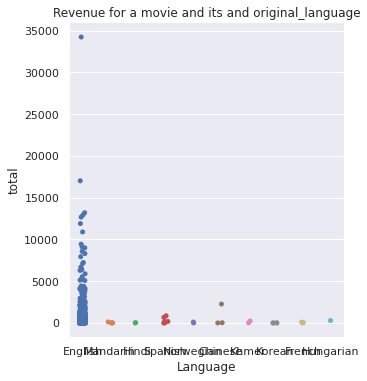

In [65]:
sns.catplot(x='Language', y='total', data=train.loc[train['Language'].isin(train['Language'].value_counts().head(10).index)])
plt.title('Revenue for a movie and its and original_language')

In [66]:
#Creating new feature
train['originally_english'] = train.Language.apply(lambda x: 1 if x == 'English' else 0)
train['originally_english'].value_counts()

1    1411
0      38
Name: originally_english, dtype: int64

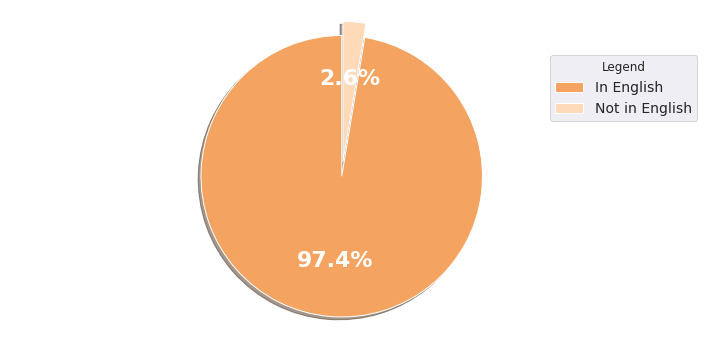

In [67]:
# plotting original data
labels = 'In English', 'Not in English'
btc_1 = [(train.originally_english == 1).sum(axis=0), (train.originally_english == 0).sum(axis=0)]
explode = (0.1, 0)

colors = ['sandybrown', 'peachpuff']

fig, ax = plt.subplots()
ax.pie(btc_1, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors, textprops={'color':"w", 'fontsize': 22, 'weight':"bold"})
ax.axis('equal') # ensures chart is a circle

ax.legend(labels,
          title="Legend",
          loc="center left",
          fontsize=14,
          bbox_to_anchor=(0.8, 0.25, 0.5, 1))

plt.show()

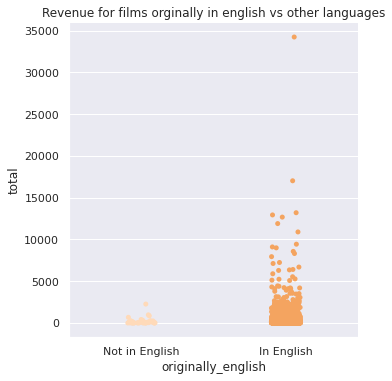

In [68]:
pal2 = ['peachpuff', 'sandybrown']

ax = sns.catplot(x='originally_english', y='total', data=train, palette=pal2);
plt.title('Revenue for films orginally in english vs other languages');

labels = 'Not in English', 'In English'
ax.set_xticklabels(labels)

In [69]:
train_features.append('originally_english')

In [74]:
#analysis of correlation and create log feature probably
corr, _ = pearsonr(train['originally_english'], train['total'])
print('Pearsons correlation between in_english and total comments: %.3f' % corr)

Pearsons correlation between in_english and total comments: 0.040


# ***Overview***

In [75]:
#overview
print('Movies missing an overview:',train.Description.isna().sum())

Movies missing an overview: 0


In [76]:
train.Description = train.Description.fillna("")
train['overview_len'] = train.Description.apply(len)

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


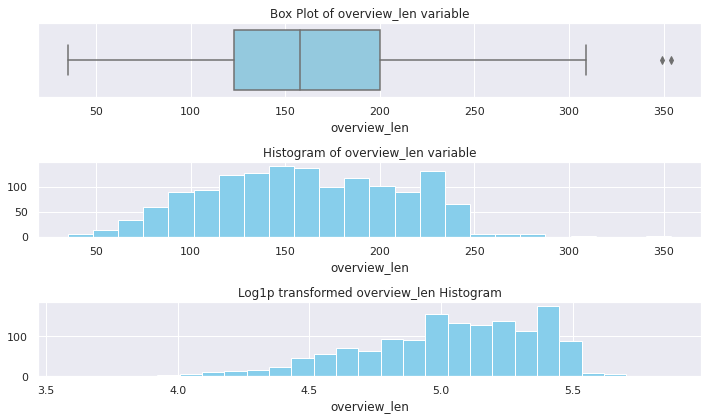

In [77]:
f, ax = plt.subplots(3, figsize=(10,6))

sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x=train.overview_len, ax = ax[0], color='skyblue')
ax[0].set_title("Box Plot of overview_len variable")
sns.distplot(a=train.overview_len, kde = False, ax = ax[1], color='skyblue', hist_kws=dict(alpha=1))
ax[1].set_title("Histogram of overview_len variable")
sns.distplot(a=np.log1p(train.overview_len), kde = False, ax = ax[2], color='skyblue', hist_kws=dict(alpha=1))
ax[2].set_title("Log1p transformed overview_len Histogram")
f.tight_layout()

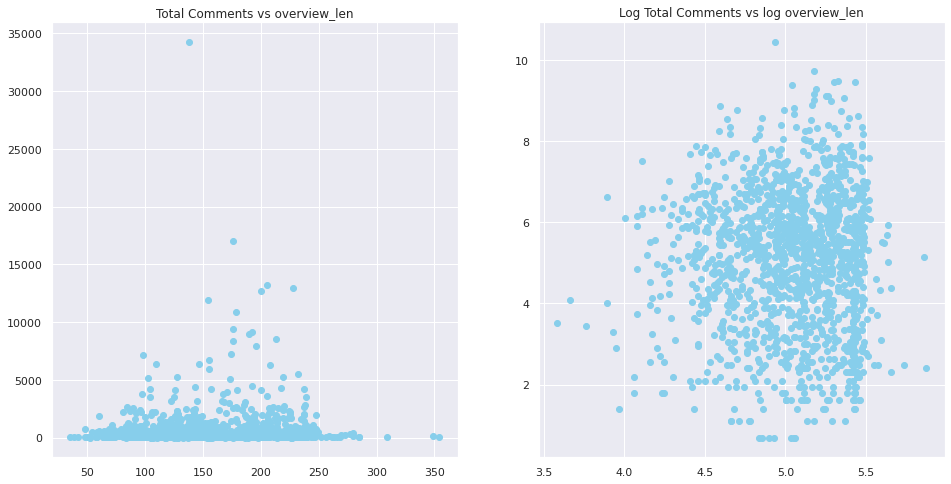

In [78]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['overview_len'], train['total'], color='skyblue')
plt.title('Total Comments vs overview_len');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['overview_len']), np.log1p(train['total']), color='skyblue')
plt.title('Log Total Comments vs log overview_len');

In [79]:
# calculate Pearson's correlation
corr, _ = pearsonr(train['overview_len'], train['total'])
print('Pearsons correlation between overview_len and total comments: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['overview_len']), np.log1p(train['total']))
print('Pearsons correlation between log transformed  overview_len and log transformed total comments:: %.3f' % corr)

Pearsons correlation between overview_len and total comments: 0.030
Pearsons correlation between log transformed  overview_len and log transformed total comments:: -0.006


In [80]:
cols_to_drop.append('Description')

In [81]:
train.columns

Index(['Movie', 'Movie_Link', 'TrailerPublishDate', 'Budget', 'Language',
       'Time_minute', 'Genres', 'FirstGenre', 'MPAA', 'MovieDirectors',
       'DirectorID', 'Movie_Stars', 'StarsID1', 'StarsID2', 'StarsID3',
       'StarsID4', 'Description', 'Countries', 'Follows',
       'ProductionCompanies', 'ReleaseDate', 'mean', 'median', 'std', 'total',
       'Label', 'title_len', 'log_total', 'has_collection', 'budget_processed',
       'genres_reform', 'Biography', 'Drama', 'History', 'Crime', 'Mystery',
       'Action', 'Adventure', 'Horror', 'Thriller', 'Sci-Fi', 'Comedy',
       'Animation', 'Documentary', 'Romance', 'Family', 'Musical', 'Sport',
       'Fantasy', 'Western', 'War', 'News', 'num_genres', 'genre_rank',
       'originally_english', 'overview_len'],
      dtype='object')

# ***Production Companies*** 


In [82]:
def concomp(onecol):
  onecol = str(onecol)
  return (onecol.split(','))

In [83]:
def count(onecol):
  cnt = 0
  for i in range(len(onecol)):
    if(onecol[i]!=""):
      cnt+=1
  return cnt

In [84]:
train['ProductionCompanies'].head(10)

0    Participant,Willi Hill,Killer Content,Amblin P...
1    Fred Films,Stage 6 Films,Metro International E...
2    Alcon Entertainment,DMG Entertainment,Studio B...
3                                     After Dark Films
4    Universal Pictures,Platinum Dunes,Blumhouse Pr...
5    Twentieth Century Fox,Gotham Group,Temple Hill...
6    Screen Australia,Causeway Films,The South Aust...
7    Universal Pictures,Blackmaled Productions,Hive...
8     BenderSpink,New Line Cinema,RatPac Entertainment
9    Alliance Films,Automatik Entertainment,Blumhou...
Name: ProductionCompanies, dtype: object

In [86]:
train['ProductionCompanies'].isna().sum()

19

In [87]:
train['ProductionCompanies'] = train['ProductionCompanies'].fillna("")

In [88]:
train['production_companies_reform']= train['ProductionCompanies'].apply(concomp)

In [89]:
train['production_companies_reform']

0       [Participant, Willi Hill, Killer Content, Ambl...
1       [Fred Films, Stage 6 Films, Metro Internationa...
2       [Alcon Entertainment, DMG Entertainment, Studi...
3                                      [After Dark Films]
4       [Universal Pictures, Platinum Dunes, Blumhouse...
                              ...                        
1444    [Relativity Media, SkyLand Entertainment, Virg...
1445    [Amazon Studios, Gravier Productions, Perdido ...
1446    [Covert Media, Dune Films, Imagine Entertainme...
1447    [Visiona Romantica, Double Feature Films, Film...
1448             [Twentieth Century Fox, LBI Productions]
Name: production_companies_reform, Length: 1449, dtype: object

In [91]:
# how many production company each movie has
train['num_studios'] = train.production_companies_reform.apply(count)
train['num_studios'].value_counts()

3     269
2     263
4     214
1     165
5     154
6     112
7      84
8      69
9      29
10     22
0      19
11     12
12     11
13      7
15      6
14      3
17      2
18      2
19      2
27      2
21      1
16      1
Name: num_studios, dtype: int64

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


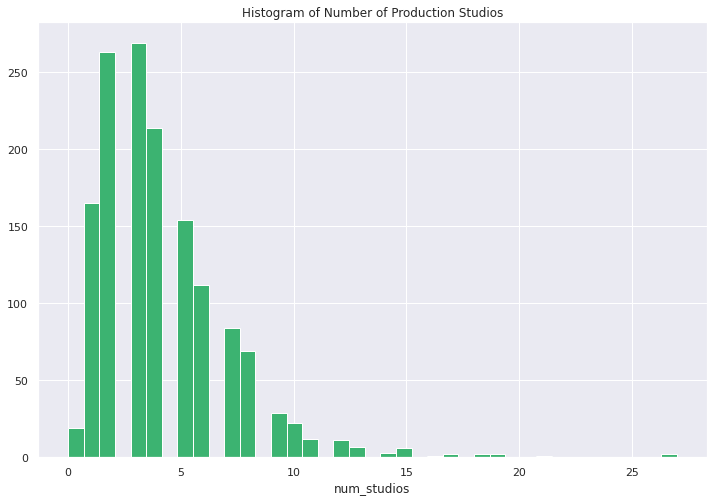

In [92]:
# plotting films by number of production studios
sns.distplot(train['num_studios'], kde=False, color='mediumseagreen', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(15,10)})
plt.title('Histogram of Number of Production Studios')
plt.show();

Most movies have between 1 and 5 production studios, with fewer films having higher numbers and some even with 0 studio partners (independent films). However, given only the sheer number of production studios it is difficult to produce a reasonable hypothesis regarding the number of comments of the film. Instead, determining the larger, more established, or otherwise previously successful production studios and applying those findings toward whether or not the dataset films in question have said studios would be a more useful way to analyze the impact of production companies.

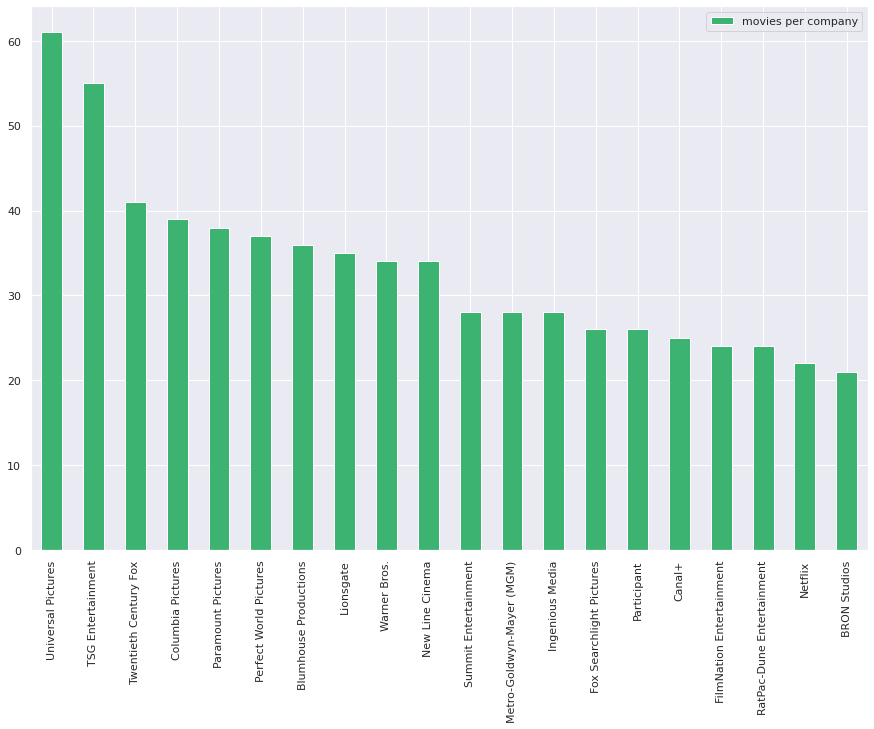

In [93]:
# production companies
companiesDict = {}
for element in train["production_companies_reform"].values:
    for company in element:
        if company not in companiesDict:
            companiesDict[company] = 1
        else:
            companiesDict[company] += 1

companies_train = pd.DataFrame.from_dict(companiesDict, orient='index', columns=["movies per company"])
companies_train.sort_values(by="movies per company", ascending=False).head(20).plot.bar(color='mediumseagreen')

companies_train.columns = ["number_of_studios"]

In [94]:
# new column for a count of the number of production studios
train['num_studios'] = train.ProductionCompanies.apply(lambda x: len(x))
train['ProductionCompanies'].value_counts()

                                                                                                                 19
Marvel Studios,Walt Disney Pictures                                                                               6
Killer Films                                                                                                      2
Vertigo Films                                                                                                     2
LD Entertainment                                                                                                  2
                                                                                                                 ..
Gulfstream Pictures,Happy Madison Productions,Karz Entertainment,Warner Bros.                                     1
Universal Pictures,Legendary Entertainment,Will Packer Productions,Khalabo Ink Society,Perfect World Pictures     1
New Regency Productions,New Regency Productions,Escape Artists,Studio Ba

Using the number of movies per production company may be useful for determining what the biggest studios are, and correlating how the size of a production company influences the success of its films. There are two possibilities; either 1. a larger studio has the funding and means to draw in big-name cast and crew, with the necessary experience to turn that into a successful film project or 2. the studio is too franchised to create successful novel ideas and merely continually pumps out mediocre performing films. While some of both is likely possible, machine learning will help to weigh the relative influence of studio size on the movie's predicted comments. Marking whether or not one of these major studios is involved in a film will be a useful feature for determining this connection.

In [95]:
df = train.copy(deep=True)

In [96]:
# bivariate analysis of comments with production studios
# production companies copy
companiesDict2 = {}
for element in df["production_companies_reform"].values:
    for company in element:
        if company not in companiesDict2:
            companiesDict2[company] = 1
        else:
            companiesDict2[company] += 1

companies_df = pd.DataFrame.from_dict(companiesDict2, orient='index', columns=["movies per company"])

companies_df.columns = ["number_of_studios"]

# creating a callable index for production studios
companies_df.index.values
for g in companies_df.index.values:
    df[g] = df['production_companies_reform'].apply(lambda x: 1 if g in x else 0)

# median number of comments per production studio
for i, g in enumerate(companies_df.index.values):
    companies_df.loc[g, "median_comm"] = df[df[g]==1].total.median()
    
companies_df.sort_values(by=["number_of_studios", "median_comm"], ascending=False).head(10)

# mean revenue per production studio
for i, g in enumerate(companies_df.index.values):
    companies_df.loc[g, "mean_comm"] = df[df[g]==1].total.mean()

companies_df.sort_values(by=["number_of_studios", "mean_comm"], ascending=False).head(10)

# total revenue per production studio
for i, g in enumerate(companies_df.index.values):
    companies_df.loc[g, "sum_comm"] = df[df[g]==1].total.sum()

companies_df.sort_values(by=["number_of_studios", "sum_comm"], ascending=False).head(10)

,number_of_studios,median_comm,mean_comm,sum_comm
Universal Pictures,61,734.0,1475.333333,88520.0
TSG Entertainment,55,433.0,929.000000,51095.0
Twentieth Century Fox,41,727.0,1227.780488,50339.0
Columbia Pictures,39,698.0,1493.358974,58241.0
Paramount Pictures,38,689.0,1861.921053,70753.0
Perfect World Pictures,37,661.5,2244.633333,67339.0
Blumhouse Productions,36,744.0,1632.138889,58757.0
Lionsgate,35,395.0,668.828571,23409.0
Warner Bros.,34,680.5,1453.852941,49431.0
New Line Cinema,34,619.5,916.470588,31160.0


Text(0.5, 0, 'Production Studio')

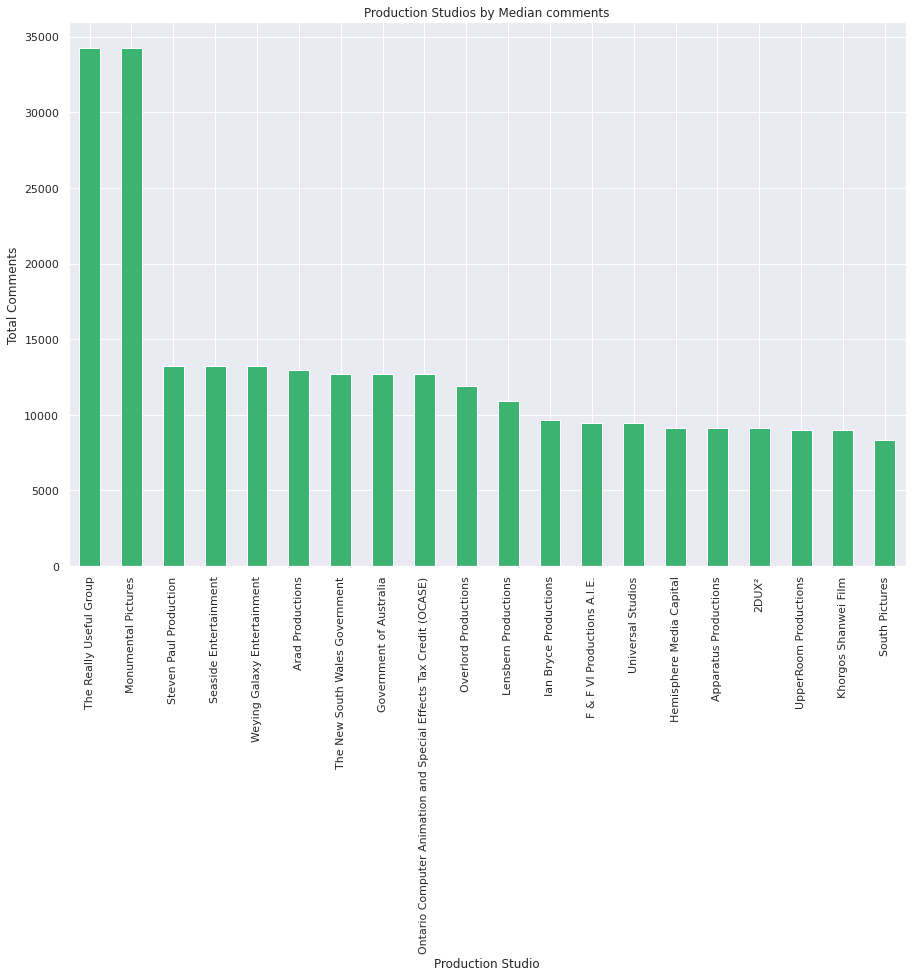

In [97]:
# production studios by median revenue
companies_df.sort_values(by=["median_comm"], ascending=False).median_comm.head(20).plot.bar(color='mediumseagreen')
plt.title("Production Studios by Median comments")
plt.ylabel("Total Comments")
plt.xlabel("Production Studio")

Text(0.5, 0, 'Production Studio')

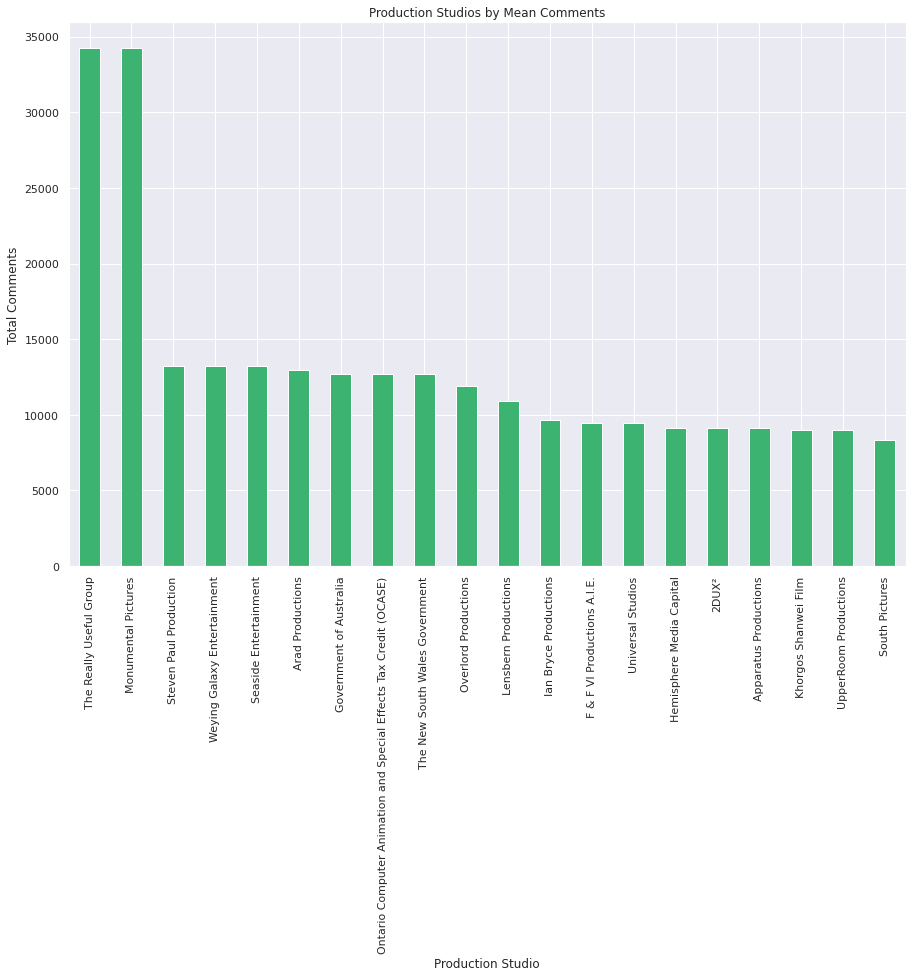

In [99]:
# production studios by mean total comments
companies_df.sort_values(by=["mean_comm"], ascending=False).mean_comm.head(20).plot.bar(color='mediumseagreen')
plt.title("Production Studios by Mean Comments")
plt.ylabel("Total Comments")
plt.xlabel("Production Studio")

Text(0.5, 0, 'Production Studio')

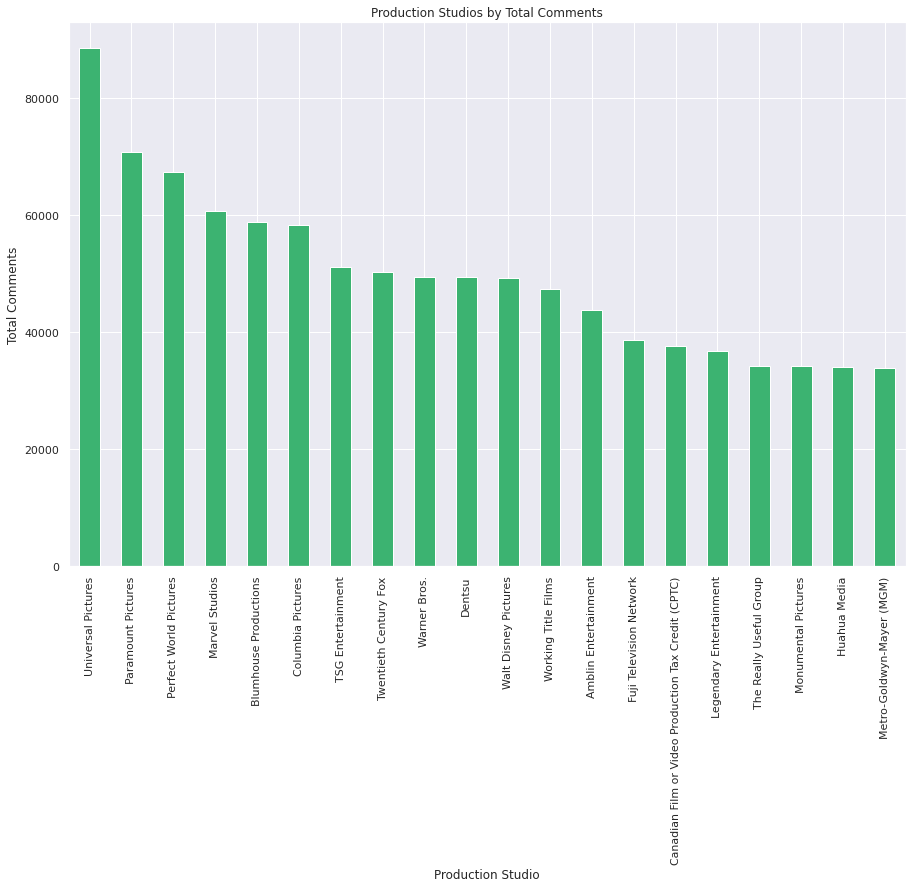

In [100]:
# production studios by total revenue
companies_df.sort_values(by=["sum_comm"], ascending=False).sum_comm.head(20).plot.bar(color='mediumseagreen')
plt.title("Production Studios by Total Comments")
plt.ylabel("Total Comments")
plt.xlabel("Production Studio")

the focus on primary studios should also be tried.

Text(0.5, 0, 'Production Studio')

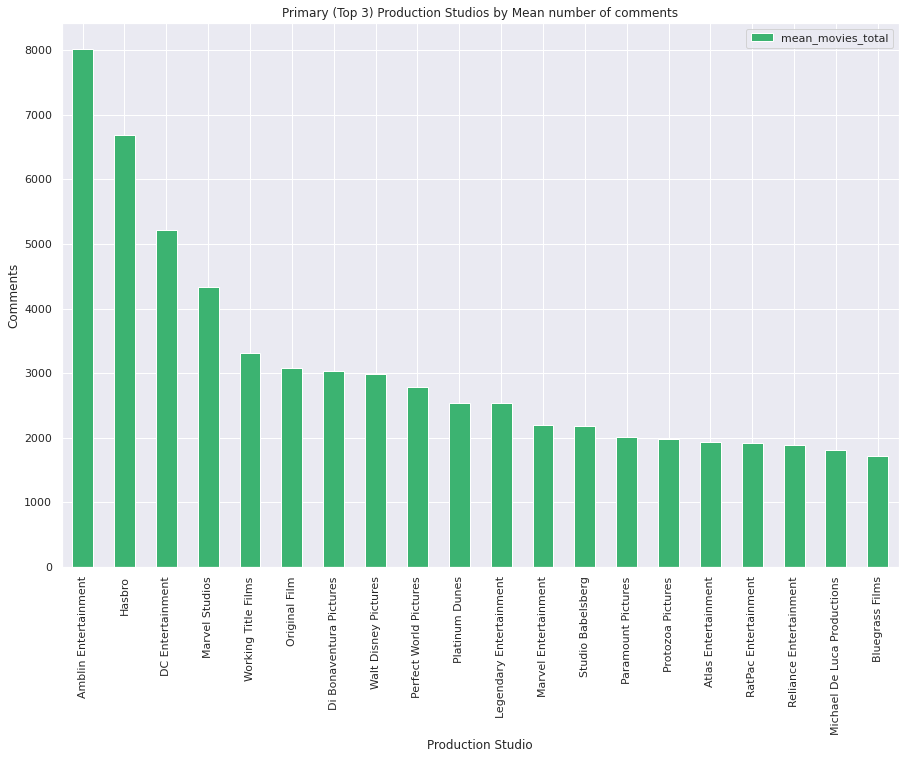

In [101]:
# isolating the primary production studios for the films
studiosDict = {}
for element in train[["total", "production_companies_reform"]].values:
   # compare results when looking at x top production companies in films vs all affiliated studios 
    temp = 3
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in studiosDict:
            studiosDict[element[1][i]] = [element[0], 1]
        else:
            studiosDict[element[1][i]][0] += element[0]
            studiosDict[element[1][i]][1] += 1    

studiosDict = {k: v for k, v in studiosDict.items() if v[1] >= 3}

for company in studiosDict:
    studiosDict[company][0] = studiosDict[company][0]/studiosDict[company][1]
    studiosDict[company] = studiosDict[company][0]


    
    
studios_train = pd.DataFrame.from_dict(studiosDict, orient='index', columns=["mean_movies_total"])
studios_train.sort_values(by="mean_movies_total", ascending=False).head(20).plot.bar(color='mediumseagreen')
plt.title("Primary (Top 3) Production Studios by Mean number of comments")
plt.ylabel("Comments")
plt.xlabel("Production Studio")

<built-in method keys of dict object at 0x7f293a84ef50>


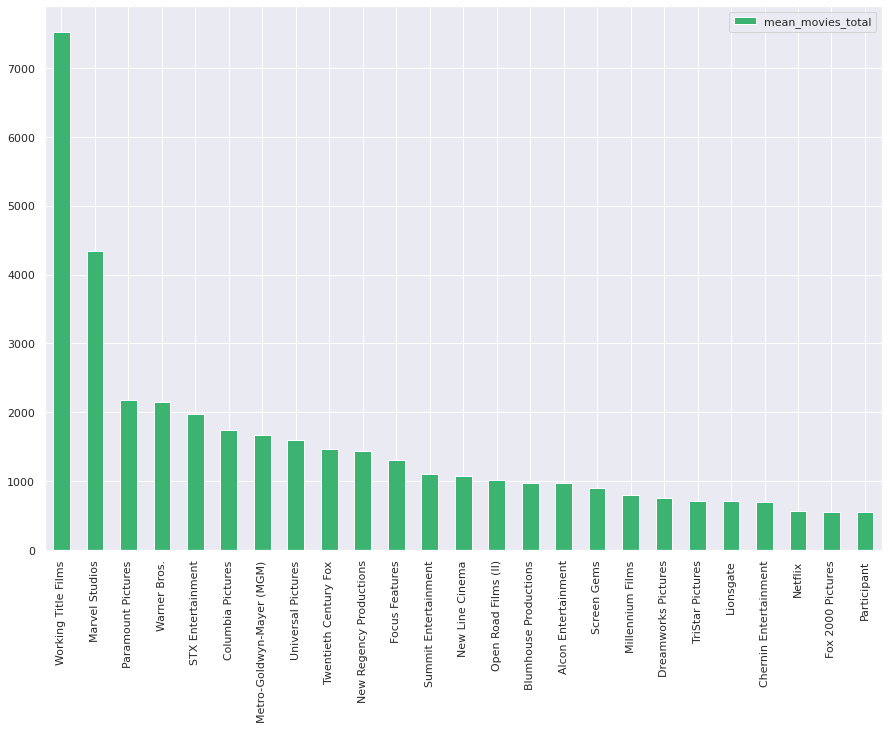

In [102]:
topStudiosDict = {}
for element in train[["total", "production_companies_reform"]].values:
   # compare results when looking at x top studios
    temp = 1
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in topStudiosDict:
            topStudiosDict[element[1][i]] = [element[0], 1]
        else:
            topStudiosDict[element[1][i]][0] += element[0]
            topStudiosDict[element[1][i]][1] += 1    

topStudiosDict = {k: v for k, v in topStudiosDict.items() if v[1] >= 5}

for company in topStudiosDict:
    topStudiosDict[company][0] = topStudiosDict[company][0]/topStudiosDict[company][1]
    topStudiosDict[company] = topStudiosDict[company][0]


    
print(topStudiosDict.keys)   
studios_df = pd.DataFrame.from_dict(topStudiosDict, orient='index', columns=["mean_movies_total"])
studios_df.sort_values(by="mean_movies_total", ascending=False).head(25).plot.bar(color='mediumseagreen')

In [103]:
# Sort both of our dicts of studios and top studios to more easily access the 'most successful studios'
topStudiosDict = {k: v for k, v in sorted(topStudiosDict.items(), key=lambda item: item[1], reverse = True)}
studiosDict = {k: v for k, v in sorted(studiosDict.items(), key=lambda item: item[1], reverse = True)}


# function to check if lead role is a 'top studio'
def checkTopStudios(studio):
    if len(studio) < 1 or studio[0] not in list(topStudiosDict)[:25]:
        return 0
    else:
        return 1

def checkStudios(studio):
    if len(studio) < 1:
        return 0
    count = 0
    for company in studio[:5]:
        if company in list(studiosDict)[:100]:
            count += 1
    return count

#Creating a feature for top production studios
train['topStudio'] = train['production_companies_reform'].apply(lambda x: checkTopStudios(x))
#Creating feature for number of top studios
train['numTopStudios'] = train['production_companies_reform'].apply(lambda x: checkStudios(x))

print(train['topStudio'].value_counts())
print()
print(train['numTopStudios'].value_counts())

0    1131
1     318
Name: topStudio, dtype: int64

0    838
1    271
2    198
3     99
4     41
5      2
Name: numTopStudios, dtype: int64


In [107]:
# analysis of correlation and create log feature
corr, _ = pearsonr(train['topStudio'], train['total'])
print('Pearsons correlation between topStudio and total comments: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['topStudio']), np.log1p(train['total']))
print('Pearsons correlation between log topStudio and total comments: %.3f' % corr)
print()

# analysis of correlation and create log feature
corr, _ = pearsonr(train['numTopStudios'], train['total'])
print('Pearsons correlation between numTopStudios and comments: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['numTopStudios']), np.log1p(train['total']))
print('Pearsons correlation between log numTopStudios and total comments: %.3f' % corr)
print()

# analysis of correlation and create log feature
corr, _ = pearsonr(train['num_studios'], train['total'])
print('Pearsons correlation between num_studios and total comments: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['num_studios']), np.log1p(train['total']))
print('Pearsons correlation between log num_studios and total comments: %.3f' % corr)

Pearsons correlation between topStudio and total comments: 0.324
Pearsons correlation between log topStudio and total comments: 0.459

Pearsons correlation between numTopStudios and comments: 0.379
Pearsons correlation between log numTopStudios and total comments: 0.590

Pearsons correlation between num_studios and total comments: 0.166
Pearsons correlation between log num_studios and total comments: 0.351


# ***Production Countries***

In [108]:
train.columns

Index(['Movie', 'Movie_Link', 'TrailerPublishDate', 'Budget', 'Language',
       'Time_minute', 'Genres', 'FirstGenre', 'MPAA', 'MovieDirectors',
       'DirectorID', 'Movie_Stars', 'StarsID1', 'StarsID2', 'StarsID3',
       'StarsID4', 'Description', 'Countries', 'Follows',
       'ProductionCompanies', 'ReleaseDate', 'mean', 'median', 'std', 'total',
       'Label', 'title_len', 'log_total', 'has_collection', 'budget_processed',
       'genres_reform', 'Biography', 'Drama', 'History', 'Crime', 'Mystery',
       'Action', 'Adventure', 'Horror', 'Thriller', 'Sci-Fi', 'Comedy',
       'Animation', 'Documentary', 'Romance', 'Family', 'Musical', 'Sport',
       'Fantasy', 'Western', 'War', 'News', 'num_genres', 'genre_rank',
       'originally_english', 'overview_len', 'production_companies_reform',
       'num_studios', 'topStudio', 'numTopStudios'],
      dtype='object')

In [109]:
print('Movies missing production countries:',train.Countries.isna().sum())

Movies missing production countries: 0


In [111]:
train['production_countries_processed'] = train['Countries'].apply(concomp)

In [112]:
train['num_production_countries'] = train['production_countries_processed'].apply(lambda x: len(x))

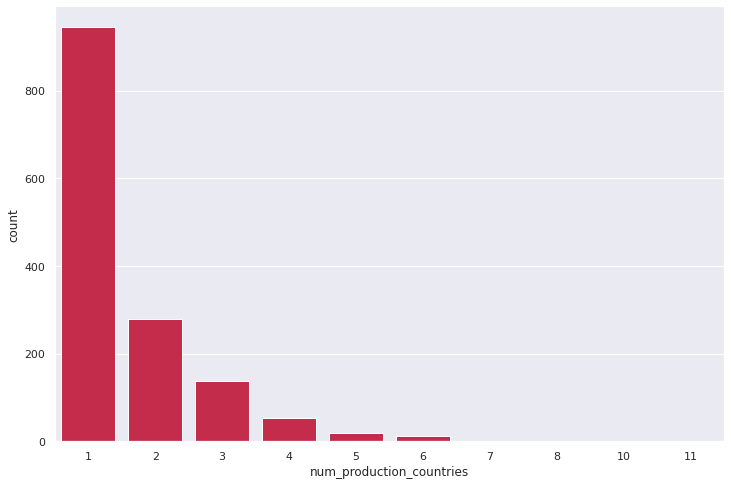

In [113]:
sns.set(rc={'figure.figsize':(12,8)})
sns.countplot(x=train.num_production_countries, color='crimson')

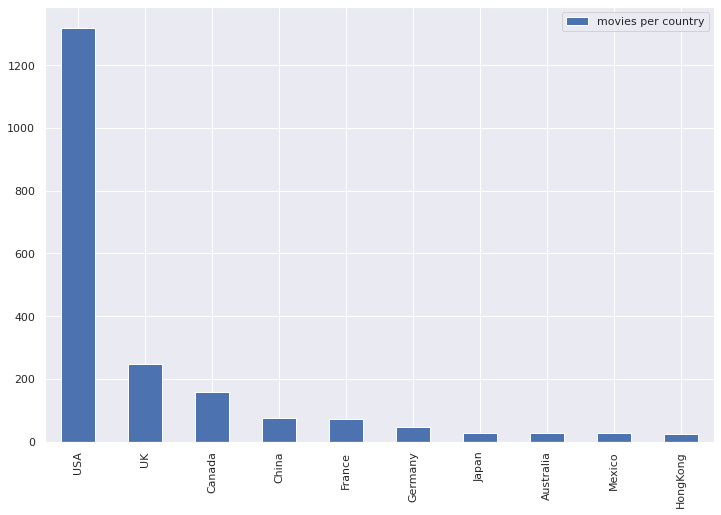

In [114]:
countriesDict = {}
for element in train["production_countries_processed"].values:
    for country in element:
        if country not in countriesDict:
            countriesDict[country] = 1
        else:
            countriesDict[country] += 1

countries_train = pd.DataFrame.from_dict(countriesDict, orient='index', columns=["movies per country"])
countries_train.sort_values(by="movies per country", ascending=False).head(10).plot.bar()

We can see from the plot that the overwhelming majority of films have the United States listed as a production country, with the second highest (United Kingdom) being incredibly far behind. Because of this observation, we will not look at all of the different production countries, but instead create a feature to determine whether or not a film was produced in the United States or not.

In [115]:
#Creating new feature
train['usa_produced'] = train.production_countries_processed.apply(lambda x: 1 if 'USA' in x else 0)
train['usa_produced'].value_counts()

1    1320
0     129
Name: usa_produced, dtype: int64

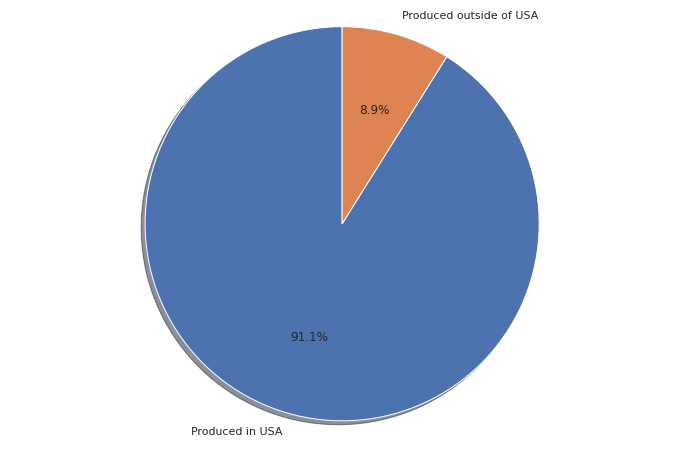

In [116]:
# plotting has a countries data
labels = 'Produced in USA', 'Produced outside of USA'
btc_1 = [sum(train.usa_produced), (train.usa_produced == 0).sum(axis=0)]


fig, ax = plt.subplots()
ax.pie(btc_1, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal') # ensures chart is a circle

plt.show()

Text(0.5, 1.0, 'total comments based on number of production countries')

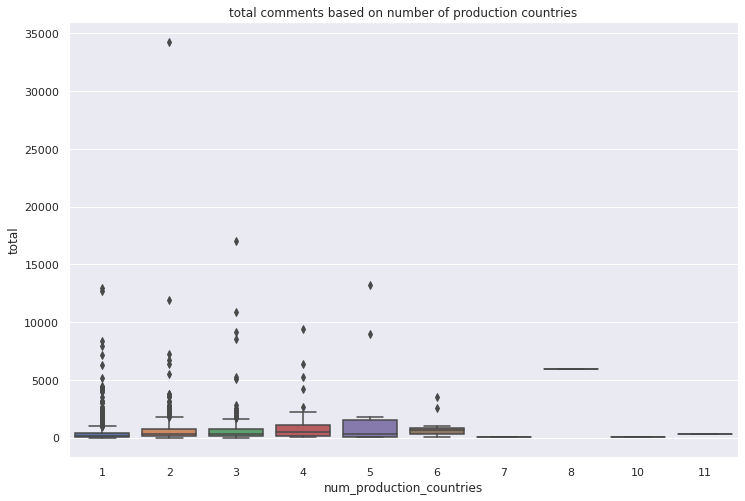

In [117]:
sns.boxplot(x='num_production_countries', y='total', data=train)
plt.title('total comments based on number of production countries')

In [118]:
# calculate Pearson's correlation
corr, _ = pearsonr(train['num_production_countries'], train['total'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.150


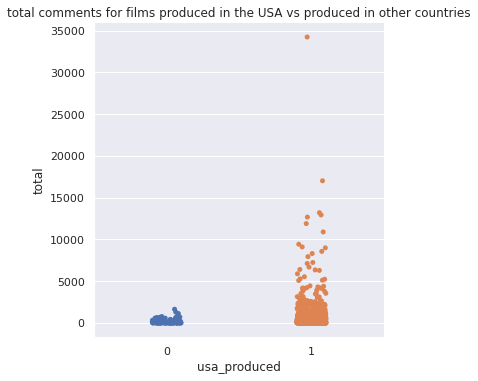

In [119]:
sns.catplot(x='usa_produced', y='total', data=train);
plt.title('total comments for films produced in the USA vs produced in other countries');

In [120]:
# calculate Pearson's correlation
corr, _ = pearsonr(train['usa_produced'], train['total'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.084


We observe a small positive correlation between our created feature and the total comments. While the correlation is not incredibly strong, it may be useful to include in our model.



# ***Release Date***


In [121]:
train.columns

Index(['Movie', 'Movie_Link', 'TrailerPublishDate', 'Budget', 'Language',
       'Time_minute', 'Genres', 'FirstGenre', 'MPAA', 'MovieDirectors',
       'DirectorID', 'Movie_Stars', 'StarsID1', 'StarsID2', 'StarsID3',
       'StarsID4', 'Description', 'Countries', 'Follows',
       'ProductionCompanies', 'ReleaseDate', 'mean', 'median', 'std', 'total',
       'Label', 'title_len', 'log_total', 'has_collection', 'budget_processed',
       'genres_reform', 'Biography', 'Drama', 'History', 'Crime', 'Mystery',
       'Action', 'Adventure', 'Horror', 'Thriller', 'Sci-Fi', 'Comedy',
       'Animation', 'Documentary', 'Romance', 'Family', 'Musical', 'Sport',
       'Fantasy', 'Western', 'War', 'News', 'num_genres', 'genre_rank',
       'originally_english', 'overview_len', 'production_companies_reform',
       'num_studios', 'topStudio', 'numTopStudios',
       'production_countries_processed', 'num_production_countries',
       'usa_produced'],
      dtype='object')

In [122]:
# release date data manipulation
# naming a date-specific dataframe for housekeeping
train_date = train['ReleaseDate']

# converting to datetime format, with .dt used for accessing quantities
train_date = pd.to_datetime(train_date)
train_date.dt
print(train_date)

0      2019-11-22
1      2017-11-02
2      2015-12-02
3      2013-05-21
4      2013-05-31
          ...    
1444   2013-03-01
1445   2017-12-01
1446   2015-10-23
1447   2015-12-25
1448   2014-04-17
Name: ReleaseDate, Length: 1449, dtype: datetime64[ns]


In [124]:

print(train.ReleaseDate.describe())
print()
print(train_date.dt.year.describe())

count           1449
unique           789
top       2014-10-10
freq              11
Name: ReleaseDate, dtype: object

count    1449.000000
mean     2015.825397
std         1.810197
min      2013.000000
25%      2014.000000
50%      2016.000000
75%      2017.000000
max      2020.000000
Name: ReleaseDate, dtype: float64


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


Text(0.5, 1.0, 'Year of Release Date by Number of Films')

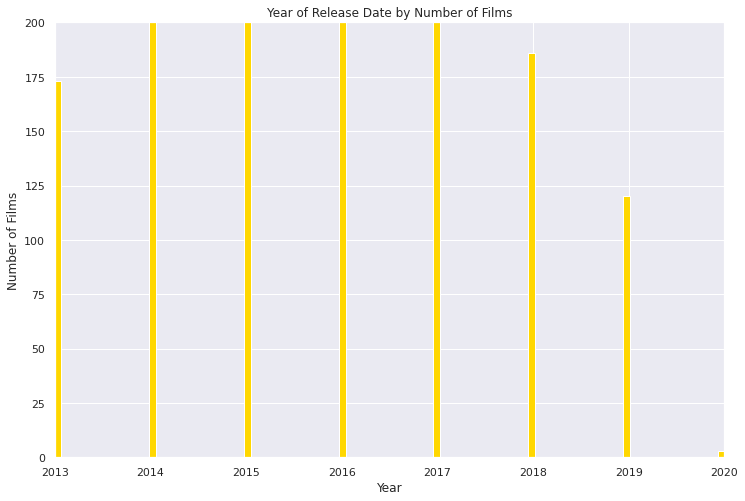

In [125]:
# plotting the year of the films release
fig, dx = plt.subplots()
sns.distplot(train_date.dt.year, bins=99, kde=False, color='gold', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(12, 6)})

dx.set(xlim=(2013, 2020),ylim=(0,200))
dx.set_xlabel("Year")
dx.set_ylabel("Number of Films")
dx.set_title("Year of Release Date by Number of Films")

Finding a relationship between the years with above average number films and total comments could be an interesting direction for investigation.

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


[Text(0, 0, ''),
 Text(0, 0, 'Monday'),
 Text(0, 0, 'Tuesday'),
 Text(0, 0, 'Wednesday'),
 Text(0, 0, 'Thursday'),
 Text(0, 0, 'Friday'),
 Text(0, 0, 'Saturday'),
 Text(0, 0, 'Sunday'),
 Text(0, 0, '')]

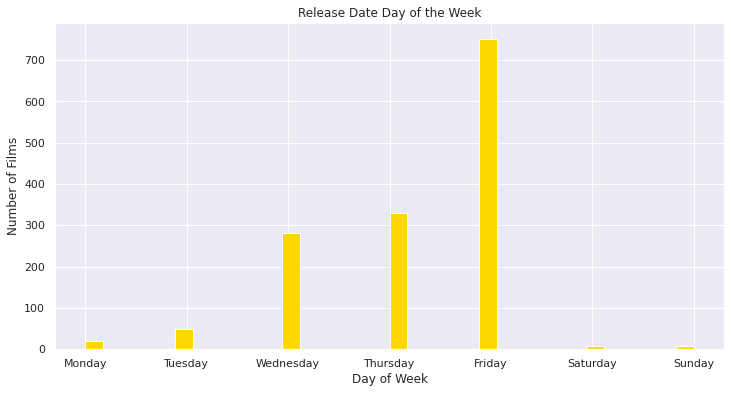

In [126]:
# plotting the films release day of the week
fig, ex = plt.subplots()
sns.distplot(train_date.dt.dayofweek, kde=False, color='gold', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(15,6)})

ex.set_xlabel("Day of Week")
ex.set_ylabel("Number of Films")
ex.set_title("Release Date Day of the Week")

labels = [item.get_text() for item in ex.get_xticklabels()]
labels[1] = 'Monday'
labels[2] = 'Tuesday'
labels[3] = 'Wednesday'
labels[4] = 'Thursday'
labels[5] = 'Friday'
labels[6] = 'Saturday'
labels[7] = 'Sunday'

ex.set_xticklabels(labels)

The dayofweek data shows a clear outlier in Friday release days, which is 
somewhat obviously tied to the end of the common Monday to Friday five day workweek. Individuals are more likely to attend a several hour long event after work if they have fewer responsibilities the following day. Unexpectedly, Saturday release dates are lower even than Tuesday, Wednesday, and Thursday - it might be logical to assume many movie-goers would attend a film opening on Saturday.

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


Text(0.5, 1.0, 'Release Date Day of the Year')

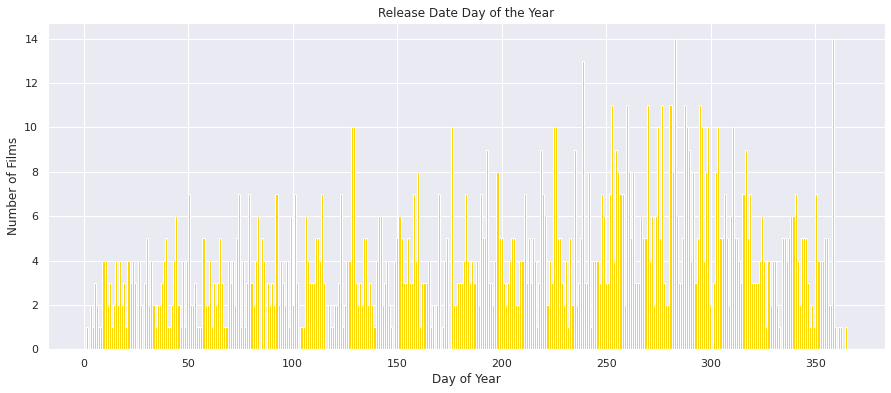

In [127]:
# plotting the films release day of the year
fig, fx = plt.subplots()
sns.distplot(train_date.dt.dayofyear, bins=365, kde=False, color='gold', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(15,6)})

fx.set_xlabel("Day of Year")
fx.set_ylabel("Number of Films")
fx.set_title("Release Date Day of the Year")

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


Text(0.5, 1.0, 'Release Date Month of the Year')

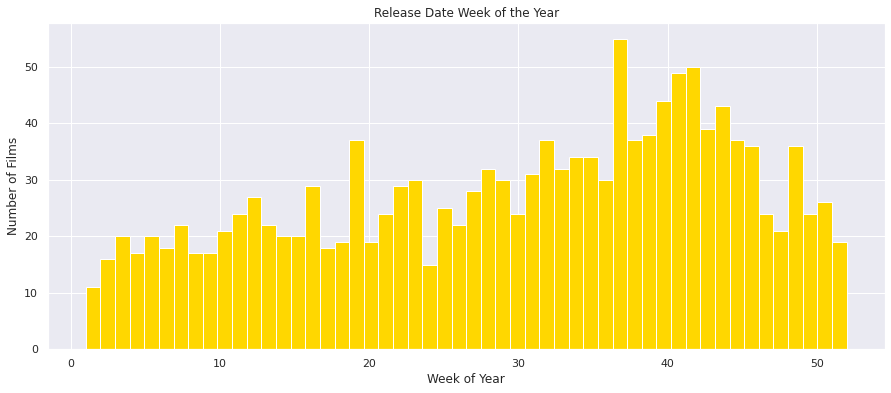

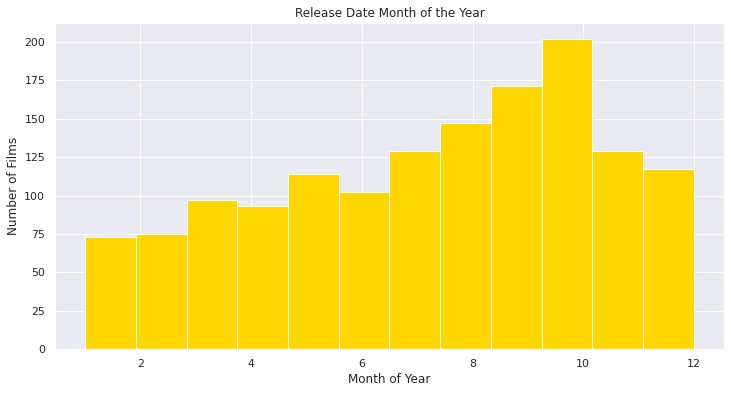

In [128]:
# plotting the films release week of the year
fig, gx = plt.subplots()
sns.distplot(train_date.dt.weekofyear, bins=52, kde=False, color='gold', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(12,6)})

gx.set_xlabel("Week of Year")
gx.set_ylabel("Number of Films")
gx.set_title("Release Date Week of the Year")

print()

# plotting the films release month of the year
fig, hx = plt.subplots()
sns.distplot(train_date.dt.month, bins=12, kde=False, color='gold', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(12,6)})

hx.set_xlabel("Month of Year")
hx.set_ylabel("Number of Films")
hx.set_title("Release Date Month of the Year")

[Text(0, 0, '2013'),
 Text(0, 0, '2014'),
 Text(0, 0, '2015'),
 Text(0, 0, '2016'),
 Text(0, 0, '2017'),
 Text(0, 0, '2018'),
 Text(0, 0, '2019'),
 Text(0, 0, '2020')]

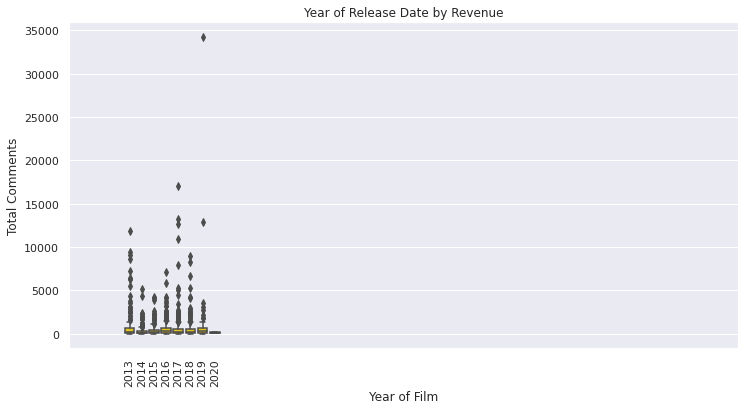

In [129]:
# bivariate year of release with comments data
fig, dx = plt.subplots()
sns.boxplot(x=train_date.dt.year, y=train['total'], color='gold')
sns.set(rc={'figure.figsize':(12, 6)})

dx.set(xlim=(-5, 50))
dx.set_xlabel("Year of Film")
dx.set_ylabel("Total Comments")
dx.set_title("Year of Release Date by Revenue")

dx.set_xticklabels(dx.get_xticklabels(), rotation=90)

[Text(0, 0, 'Monday'),
 Text(0, 0, 'Tuesday'),
 Text(0, 0, 'Wednesday'),
 Text(0, 0, 'Thursday'),
 Text(0, 0, 'Friday'),
 Text(0, 0, 'Saturday'),
 Text(0, 0, 'Sunday')]

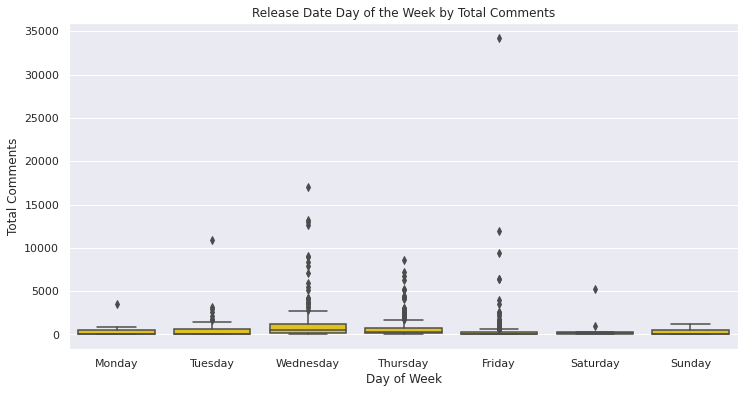

In [130]:
# bivariate day of week of release with revenue data
fig, ex = plt.subplots()
sns.boxplot(x=train_date.dt.dayofweek, y=train['total'], color='gold')
sns.set(rc={'figure.figsize':(12, 6)})

ex.set_xlabel("Day of Week")
ex.set_ylabel("Total Comments")
ex.set_title("Release Date Day of the Week by Total Comments")

labels = [item.get_text() for item in ex.get_xticklabels()]
labels[0] = 'Monday'
labels[1] = 'Tuesday'
labels[2] = 'Wednesday'
labels[3] = 'Thursday'
labels[4] = 'Friday'
labels[5] = 'Saturday'
labels[6] = 'Sunday'

ex.set_xticklabels(labels)

Surprisingly, despite the hypothesis that Friday was the most common release date because of some monetary benefit to sales, Wednesday (followed by Tuesday & Thursday) has the highest total comments. It would be interesting to investigate why this is the case, but regardless it will help inform the outcome of the model.

Text(0.5, 1.0, 'Release Date Day of the Year by total comments')

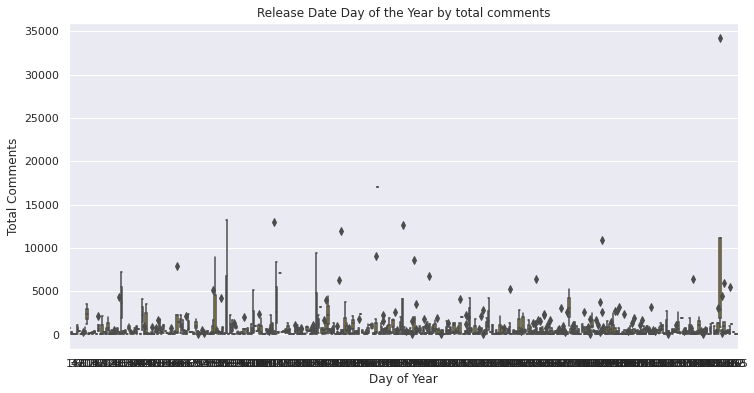

In [131]:
# bivariate day of year of release with comments data
# WIP
fig, fx = plt.subplots()
sns.boxplot(x=train_date.dt.dayofyear, y=train['total'], color='gold')
sns.set(rc={'figure.figsize':(12, 6)})

fx.set_xlabel("Day of Year")
fx.set_ylabel("Total Comments")
fx.set_title("Release Date Day of the Year by total comments")

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


Text(0.5, 1.0, 'Release Date Week of the Year by Total Comments')

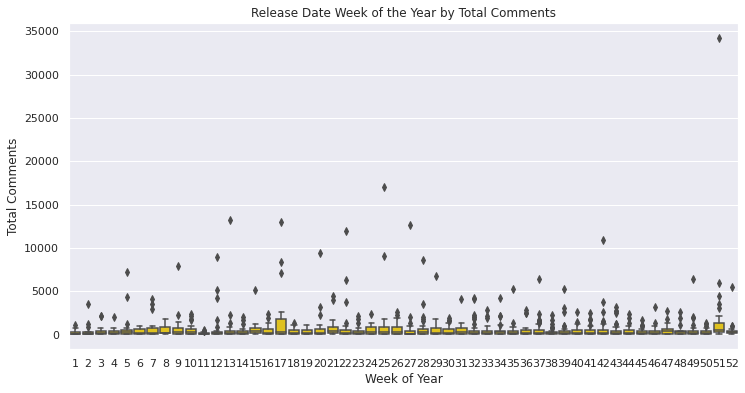

In [132]:
fig, gx = plt.subplots()
sns.boxplot(x=train_date.dt.weekofyear, y=train['total'], color='gold')
sns.set(rc={'figure.figsize':(12, 10)})

gx.set_xlabel("Week of Year")
gx.set_ylabel("Total Comments")
gx.set_title("Release Date Week of the Year by Total Comments")

Text(0.5, 1.0, 'Release Date Month by Total Comments')

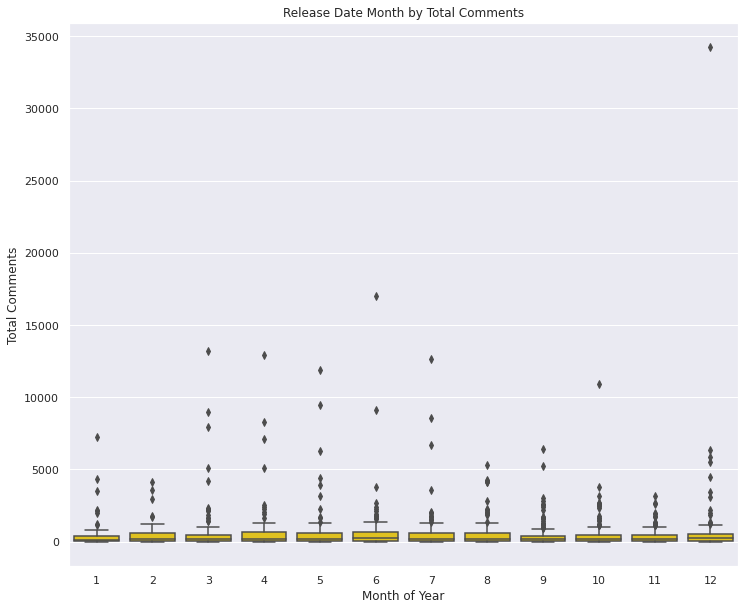

In [133]:
fig, hx = plt.subplots()
sns.boxplot(x=train_date.dt.month, y=train['total'], color='gold')
sns.set(rc={'figure.figsize':(12, 6)})

hx.set_xlabel("Month of Year")
hx.set_ylabel("Total Comments")
hx.set_title("Release Date Month by Total Comments")

In [137]:
# fill possible NA values with the statistical mode
train["ReleaseDate"] = train["ReleaseDate"].fillna(train["ReleaseDate"].mode()[0])

train['temp'] = train.ReleaseDate.apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

train["month"] = train.temp.apply(lambda x: x.month)

train["season"] = train["month"]%4

train["year"] = train.temp.apply(lambda x: x.year)

train["day_of_week"] = train.temp.apply(lambda x: x.weekday()+1)

train["week_of_year"] = train.temp.apply(lambda x: x.isocalendar()[1])


train = train.drop(['temp'], axis=1)


train["day_of_week"] = train["day_of_week"].fillna(train["day_of_week"].mode()[0])

train["year"] = train["year"].fillna(train["year"].mode()[0])

train["month"] = train["month"].fillna(train["month"].mode()[0])

train["week_of_year"] = train["week_of_year"].fillna(train["week_of_year"].mode()[0])

train["season"] = train["season"].fillna(train["season"].mode()[0])

train[["ReleaseDate", "month", "year", "day_of_week", "week_of_year", "season"]].head()

,ReleaseDate,month,year,day_of_week,week_of_year,season
0,2019-11-22,11,2019,5,47,3
1,2017-11-02,11,2017,4,44,3
2,2015-12-02,12,2015,3,49,0
3,2013-05-21,5,2013,2,21,1
4,2013-05-31,5,2013,5,22,1


In [138]:
#analysis of correlation and create log feature
corr, _ = pearsonr(train['day_of_week'], train['total'])
print('Pearsons correlation between day_of_week and total: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['day_of_week']), np.log1p(train['total']))
print('Pearsons correlation between day_of_week and total: %.3f' % corr)
print()

#analysis of correlation and create log feature
corr, _ = pearsonr(train['year'], train['total'])
print('Pearsons correlation between year and total: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['year']), np.log1p(train['total']))
print('Pearsons correlation between year and total: %.3f' % corr)
print()

#analysis of correlation and create log feature
corr, _ = pearsonr(train['month'], train['total'])
print('Pearsons correlation between month and total: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['month']), np.log1p(train['total']))
print('Pearsons correlation between month and total: %.3f' % corr)
print()

#analysis of correlation and create log feature
corr, _ = pearsonr(train['week_of_year'], train['total'])
print('Pearsons correlation between week_of_year and total: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['week_of_year']), np.log1p(train['total']))
print('Pearsons correlation between week_of_year and total: %.3f' % corr)
print()

#analysis of correlation and create log feature
corr, _ = pearsonr(train['season'], train['total'])
print('Pearsons correlation between season and total: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['season']), np.log1p(train['total']))
print('Pearsons correlation between season and total: %.3f' % corr)

Pearsons correlation between day_of_week and total: -0.167
Pearsons correlation between day_of_week and total: -0.243

Pearsons correlation between year and total: 0.041
Pearsons correlation between year and total: 0.078

Pearsons correlation between month and total: -0.021
Pearsons correlation between month and total: -0.015

Pearsons correlation between week_of_year and total: -0.014
Pearsons correlation between week_of_year and total: -0.002

Pearsons correlation between season and total: -0.027
Pearsons correlation between season and total: -0.008


# ***Trailer Publish Date***

In [140]:
# release date data manipulation
# naming a date-specific dataframe for housekeeping
train_date_trailer = train['TrailerPublishDate']

# converting to datetime format, with .dt used for accessing quantities
train_date_trailer = pd.to_datetime(train_date_trailer)
train_date_trailer.dt
print(train_date_trailer)

0      2019-09-18
1      2017-10-04
2      2015-05-26
3      2013-01-16
4      2013-04-03
          ...    
1444   2012-11-13
1445   2017-10-04
1446   2015-06-11
1447   2015-11-05
1448   2013-12-19
Name: TrailerPublishDate, Length: 1449, dtype: datetime64[ns]


In [141]:
print(train.TrailerPublishDate.describe())
print()
print(train_date_trailer.dt.year.describe())

count           1449
unique           974
top       2016-08-08
freq               8
Name: TrailerPublishDate, dtype: object

count    1449.000000
mean     2015.658385
std         1.844789
min      2012.000000
25%      2014.000000
50%      2016.000000
75%      2017.000000
max      2019.000000
Name: TrailerPublishDate, dtype: float64


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


Text(0.5, 1.0, 'Year of Publish Date by Number of Films')

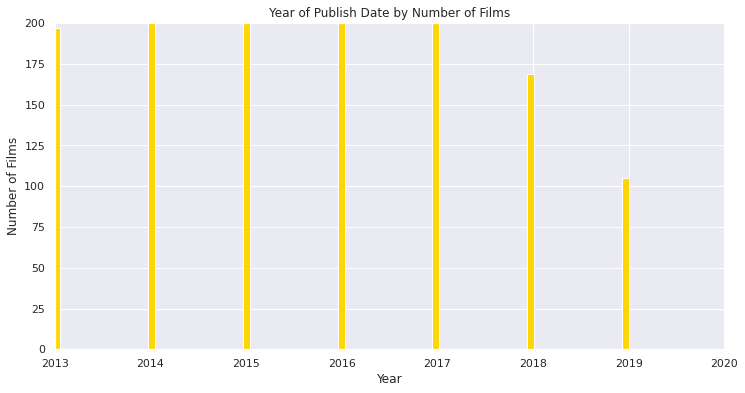

In [142]:
# plotting the year of the films release
fig, dx = plt.subplots()
sns.distplot(train_date_trailer.dt.year, bins=99, kde=False, color='gold', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(12, 6)})

dx.set(xlim=(2013, 2020),ylim=(0,200))
dx.set_xlabel("Year")
dx.set_ylabel("Number of Films")
dx.set_title("Year of Publish Date by Number of Films")

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


[Text(0, 0, ''),
 Text(0, 0, 'Monday'),
 Text(0, 0, 'Tuesday'),
 Text(0, 0, 'Wednesday'),
 Text(0, 0, 'Thursday'),
 Text(0, 0, 'Friday'),
 Text(0, 0, 'Saturday'),
 Text(0, 0, 'Sunday'),
 Text(0, 0, '')]

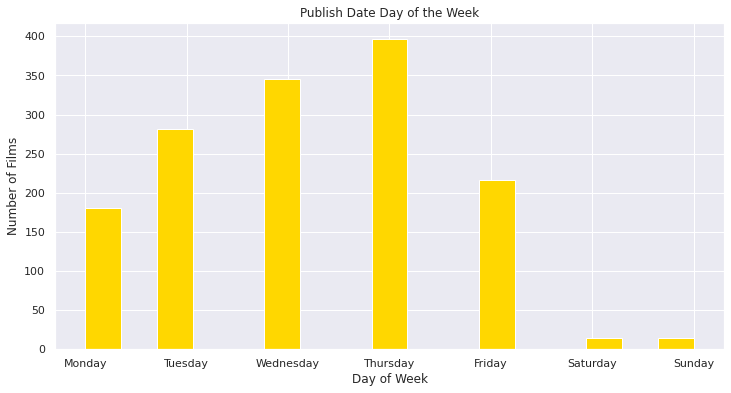

In [143]:
# plotting the films release day of the week
fig, ex = plt.subplots()
sns.distplot(train_date_trailer.dt.dayofweek, kde=False, color='gold', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(15,6)})

ex.set_xlabel("Day of Week")
ex.set_ylabel("Number of Films")
ex.set_title("Publish Date Day of the Week")

labels = [item.get_text() for item in ex.get_xticklabels()]
labels[1] = 'Monday'
labels[2] = 'Tuesday'
labels[3] = 'Wednesday'
labels[4] = 'Thursday'
labels[5] = 'Friday'
labels[6] = 'Saturday'
labels[7] = 'Sunday'

ex.set_xticklabels(labels)

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


Text(0.5, 1.0, 'Release Date Day of the Year')

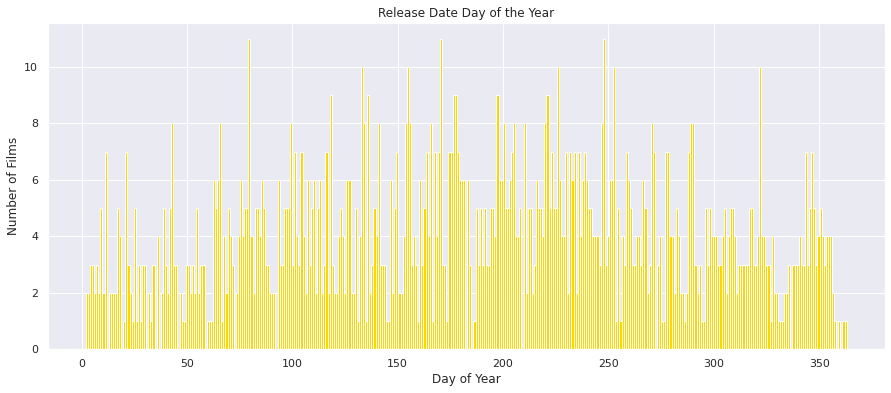

In [144]:
# plotting the films release day of the year
fig, fx = plt.subplots()
sns.distplot(train_date_trailer.dt.dayofyear, bins=365, kde=False, color='gold', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(15,6)})

fx.set_xlabel("Day of Year")
fx.set_ylabel("Number of Films")
fx.set_title("Release Date Day of the Year")

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


Text(0.5, 1.0, 'Release Date Month of the Year')

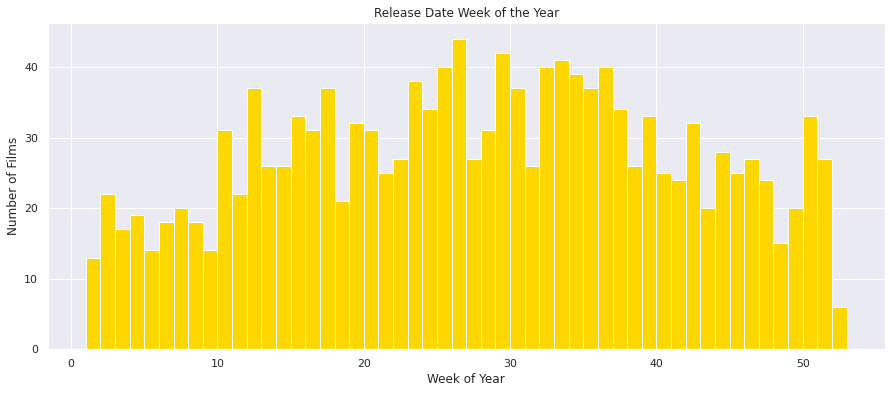

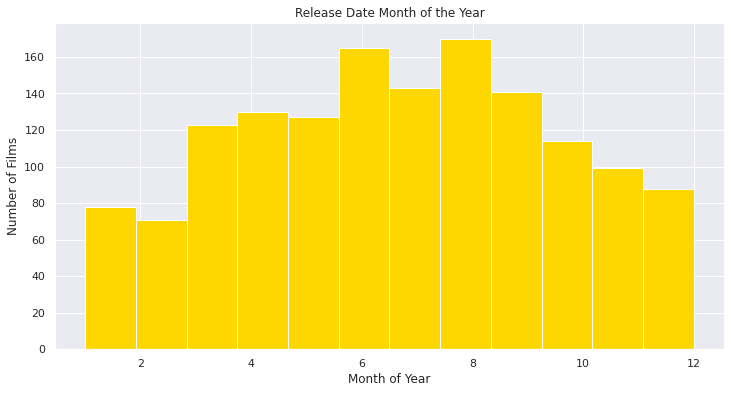

In [145]:
# plotting the films release week of the year
fig, gx = plt.subplots()
sns.distplot(train_date_trailer.dt.weekofyear, bins=52, kde=False, color='gold', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(12,6)})

gx.set_xlabel("Week of Year")
gx.set_ylabel("Number of Films")
gx.set_title("Release Date Week of the Year")

print()

# plotting the films release month of the year
fig, hx = plt.subplots()
sns.distplot(train_date_trailer.dt.month, bins=12, kde=False, color='gold', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(12,6)})

hx.set_xlabel("Month of Year")
hx.set_ylabel("Number of Films")
hx.set_title("Release Date Month of the Year")

In [154]:

# fill possible NA values with the statistical mode
train["TrailerPublishDate"] = train["TrailerPublishDate"].fillna(train["TrailerPublishDate"].mode()[0])

train['temp_trailer'] = train.TrailerPublishDate.apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

train["month_trailer"] = train.temp_trailer.apply(lambda x: x.month)

train["season_trailer"] = train["month_trailer"]%4

train["year_trailer"] = train.temp_trailer.apply(lambda x: x.year)

train["day_of_week_trailer"] = train.temp_trailer.apply(lambda x: x.weekday()+1)

train["week_of_year_trailer"] = train.temp_trailer.apply(lambda x: x.isocalendar()[1])


train = train.drop(['temp_trailer'], axis=1)


train["day_of_week_trailer"] = train["day_of_week_trailer"].fillna(train["day_of_week_trailer"].mode()[0])

train["year_trailer"] = train["year_trailer"].fillna(train["year_trailer"].mode()[0])

train["month_trailer"] = train["month_trailer"].fillna(train["month_trailer"].mode()[0])

train["week_of_year_trailer"] = train["week_of_year_trailer"].fillna(train["week_of_year_trailer"].mode()[0])

train["season_trailer"] = train["season_trailer"].fillna(train["season_trailer"].mode()[0])

train[["TrailerPublishDate", "month_trailer", "year_trailer", "day_of_week_trailer", "week_of_year_trailer", "season_trailer"]].head()

,TrailerPublishDate,month_trailer,year_trailer,day_of_week_trailer,week_of_year_trailer,season_trailer
0,2019-09-18,9,2019,3,38,1
1,2017-10-04,10,2017,3,40,2
2,2015-05-26,5,2015,2,22,1
3,2013-01-16,1,2013,3,3,1
4,2013-04-03,4,2013,3,14,0


In [155]:
#analysis of correlation and create log feature
corr, _ = pearsonr(train['day_of_week_trailer'], train['total'])
print('Pearsons correlation between day_of_week and total: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['day_of_week_trailer']), np.log1p(train['total']))
print('Pearsons correlation between day_of_week and total: %.3f' % corr)
print()

#analysis of correlation and create log feature
corr, _ = pearsonr(train['year_trailer'], train['total'])
print('Pearsons correlation between year and total: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['year_trailer']), np.log1p(train['total']))
print('Pearsons correlation between year and total: %.3f' % corr)
print()

#analysis of correlation and create log feature
corr, _ = pearsonr(train['month_trailer'], train['total'])
print('Pearsons correlation between month and total: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['month_trailer']), np.log1p(train['total']))
print('Pearsons correlation between month and total: %.3f' % corr)
print()

#analysis of correlation and create log feature
corr, _ = pearsonr(train['week_of_year_trailer'], train['total'])
print('Pearsons correlation between week_of_year and total: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['week_of_year_trailer']), np.log1p(train['total']))
print('Pearsons correlation between week_of_year and total: %.3f' % corr)
print()

#analysis of correlation and create log feature
corr, _ = pearsonr(train['season_trailer'], train['total'])
print('Pearsons correlation between season and total: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['season_trailer']), np.log1p(train['total']))
print('Pearsons correlation between season and total: %.3f' % corr)

Pearsons correlation between day_of_week and total: 0.072
Pearsons correlation between day_of_week and total: 0.036

Pearsons correlation between year and total: 0.008
Pearsons correlation between year and total: 0.040

Pearsons correlation between month and total: 0.050
Pearsons correlation between month and total: -0.012

Pearsons correlation between week_of_year and total: 0.046
Pearsons correlation between week_of_year and total: -0.014

Pearsons correlation between season and total: 0.058
Pearsons correlation between season and total: 0.063


# ***Cast***

In [156]:
train.columns

Index(['Movie', 'Movie_Link', 'TrailerPublishDate', 'Budget', 'Language',
       'Time_minute', 'Genres', 'FirstGenre', 'MPAA', 'MovieDirectors',
       'DirectorID', 'Movie_Stars', 'StarsID1', 'StarsID2', 'StarsID3',
       'StarsID4', 'Description', 'Countries', 'Follows',
       'ProductionCompanies', 'ReleaseDate', 'mean', 'median', 'std', 'total',
       'Label', 'title_len', 'log_total', 'has_collection', 'budget_processed',
       'genres_reform', 'Biography', 'Drama', 'History', 'Crime', 'Mystery',
       'Action', 'Adventure', 'Horror', 'Thriller', 'Sci-Fi', 'Comedy',
       'Animation', 'Documentary', 'Romance', 'Family', 'Musical', 'Sport',
       'Fantasy', 'Western', 'War', 'News', 'num_genres', 'genre_rank',
       'originally_english', 'overview_len', 'production_companies_reform',
       'num_studios', 'topStudio', 'numTopStudios',
       'production_countries_processed', 'num_production_countries',
       'usa_produced', 'month', 'season', 'year', 'day_of_week',
      

In [167]:
print('Movies missing a cast:',train.Movie_Stars.isna().sum())

Movies missing a cast: 0


In [168]:
#pre-processing
train['cast_processed'] = train['Movie_Stars'].apply(con)
train['cast_processed'].head(10)

0    [Mark Ruffalo, Anne Hathaway, Tim Robbins, Bil...
1    [Max Irons, Stefanie Martini, Glenn Close, Hon...
2    [Edgar Ramírez, Luke Bracey, Ray Winstone, Ter...
3    [Brett Beoubay, Jamie Bernstein, Ashley Braud,...
4    [Ethan Hawke, Lena Headey, Max Burkholder, Ade...
5    [Dylan O'Brien, Kaya Scodelario, Will Poulter,...
6    [Essie Davis, Noah Wiseman, Daniel Henshall, H...
7    [Monica Calhoun, Morris Chestnut, Melissa De S...
8    [Jason Bateman, Jason Sudeikis, Charlie Day, J...
9    [Keri Russell, Jake Brennan, Josh Hamilton, Da...
Name: cast_processed, dtype: object

In [169]:
train['num_cast'] = train['cast_processed'].apply(lambda x: len(x))
train['num_cast'].value_counts()

5    1442
4       7
Name: num_cast, dtype: int64

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


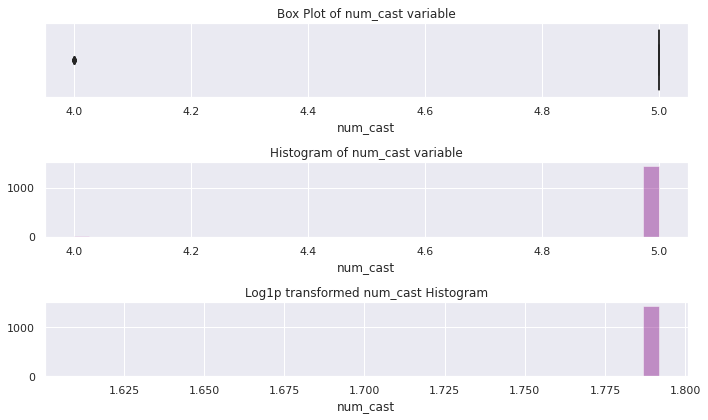

In [170]:
f, ax = plt.subplots(3, figsize=(10,6))

sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x=train.num_cast, ax = ax[0], color='purple')
ax[0].set_title("Box Plot of num_cast variable")
sns.distplot(a=train.num_cast, kde = False, ax = ax[1], color='purple')
ax[1].set_title("Histogram of num_cast variable")
sns.distplot(a=np.log1p(train.num_cast), kde = False, ax = ax[2], color='purple')
ax[2].set_title("Log1p transformed num_cast Histogram")
f.tight_layout()

In [171]:
# calculate Pearson's correlation
corr, _ = pearsonr(train['num_cast'], train['total'])
print('Pearsons correlation: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['num_cast']), np.log1p(train['total']))
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.012
Pearsons correlation: 0.043


In [172]:
train['log_num_cast'] =  np.log1p(train['num_cast'])


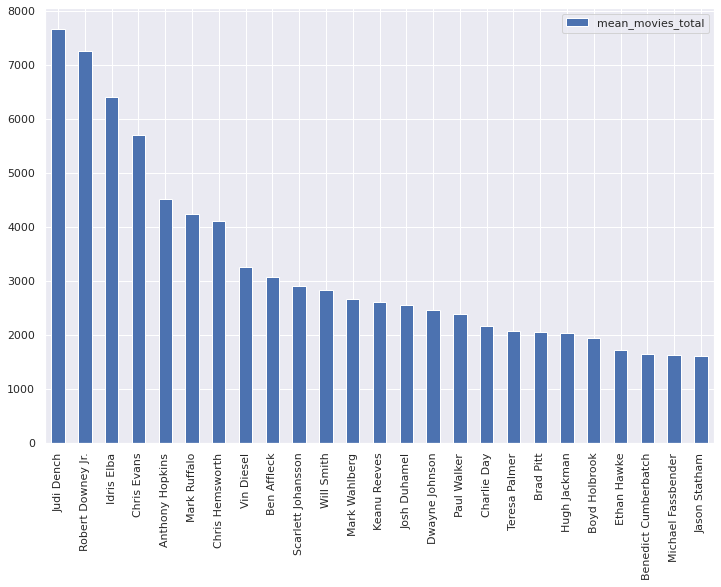

In [173]:
#cast

actorsDict = {}
for element in train[["total", "cast_processed"]].values:
   # compare results when looking at x top actors in films vs whole cast 
    temp = 4
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in actorsDict:
            actorsDict[element[1][i]] = [element[0], 1]
        else:
            actorsDict[element[1][i]][0] += element[0]
            actorsDict[element[1][i]][1] += 1    

actorsDict = {k: v for k, v in actorsDict.items() if v[1] >= 5}

for actor in actorsDict:
    actorsDict[actor][0] = actorsDict[actor][0]/actorsDict[actor][1]
    actorsDict[actor] = actorsDict[actor][0]


    
    
actors_train = pd.DataFrame.from_dict(actorsDict, orient='index', columns=["mean_movies_total"])
actors_train.sort_values(by="mean_movies_total", ascending=False).head(25).plot.bar()

This is a plot of the top 20 actors based on average total number of comments. This list is not very reliable, as it factors in anyone in the cast, meaning cameos are factored in.



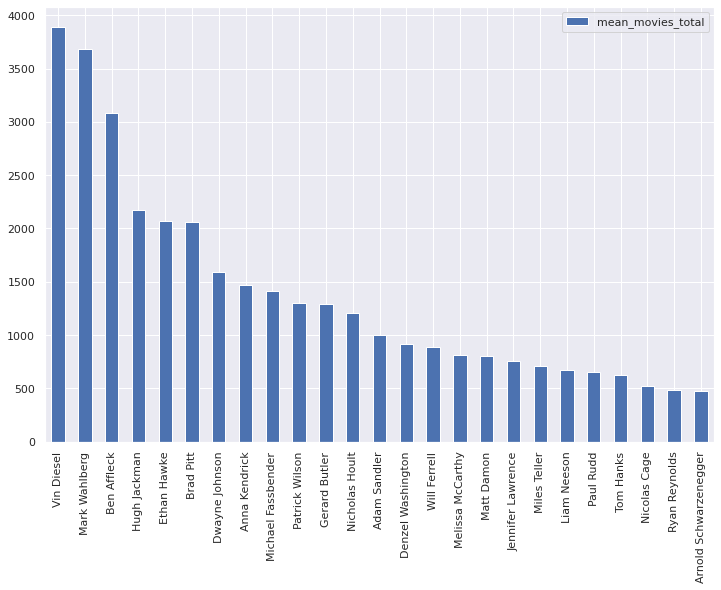

In [174]:
leadActorsDict = {}
for element in train[["total", "cast_processed"]].values:
   # compare results when looking at x top actors in films vs whole cast 
    temp = 1
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in leadActorsDict:
            leadActorsDict[element[1][i]] = [element[0], 1]
        else:
            leadActorsDict[element[1][i]][0] += element[0]
            leadActorsDict[element[1][i]][1] += 1    

leadActorsDict = {k: v for k, v in leadActorsDict.items() if v[1] >= 5}

for actor in leadActorsDict:
    leadActorsDict[actor][0] = leadActorsDict[actor][0]/leadActorsDict[actor][1]
    leadActorsDict[actor] = leadActorsDict[actor][0]


    
    
actors_train = pd.DataFrame.from_dict(leadActorsDict, orient='index', columns=["mean_movies_total"])
actors_train.sort_values(by="mean_movies_total", ascending=False).head(25).plot.bar()

This is a plot of the top 50 actors as a LEAD actor, meaning the first one credited for a film. This could be a useful feature as these actors have proven success as a lead role.



Because of how drastically different the results are depending on if you only look at the lead actor, compared to several of the lead actors, we will create a feature for each.

The first feature will be a dummy variable representing simply whether or not the lead actor of the movie is a 'top lead actor'. The second feature will be a count of how many 'top actors' the movie has in it's cast, limiting to only the top 5 actors of the cast to only factor in significant roles and not cameos.

We decided to classify a 'top actor' as an actor in the top 50 for the lead actor, and top 100 for all actors, ranked based on average total comments of past movies.

In [175]:
# Sort both of our dicts of actors and lead actors to more easily access the 'top actors'
leadActorsDict = {k: v for k, v in sorted(leadActorsDict.items(), key=lambda item: item[1], reverse = True)}
actorsDict = {k: v for k, v in sorted(actorsDict.items(), key=lambda item: item[1], reverse = True)}


# function to check if lead role is a 'top actor'
def checkLeadActor(cast):
    if len(cast) < 1 or cast[0] not in list(leadActorsDict)[:25]:
        return 0
    else:
        return 1

def checkTopActors(cast):
    if len(cast) < 1:
        return 0
    count = 0
    for actor in cast[:5]:
        if actor in list(actorsDict)[:100]:
            count += 1
    return count

#Creating a feature for top LEAD actors
train['topLeadActor'] = train['cast_processed'].apply(lambda x: checkLeadActor(x))
#Creating feature for number of top actors
train['numTopActors'] = train['cast_processed'].apply(lambda x: checkTopActors(x))

print(train['topLeadActor'].value_counts())
print()
print(train['numTopActors'].value_counts())

0    1298
1     151
Name: topLeadActor, dtype: int64

0    980
1    329
2    100
3     28
4     12
Name: numTopActors, dtype: int64


These results are questionable and our methods need further inspection. It seems a bit odd that the overwhelming majority of movies don't have a single 'top actor', but there are plenty of actors so maybe this is accurate. There is a lot of fluctuation in the results based on changing any single one of the variables, so this should be analyzed more closely before moving on.

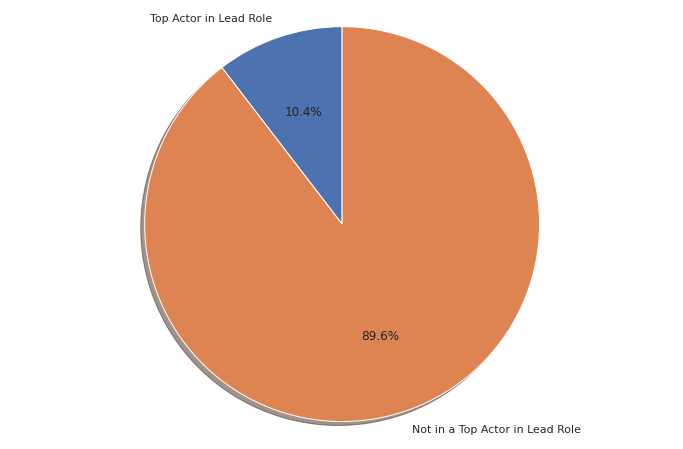

In [176]:
# plotting original data
labels = 'Top Actor in Lead Role', 'Not in a Top Actor in Lead Role'
btc_1 = [sum(train.topLeadActor), (train.topLeadActor == 0).sum(axis=0)]


fig, ax = plt.subplots()

plt.pie(btc_1, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal') # ensures chart is a circle



plt.show()

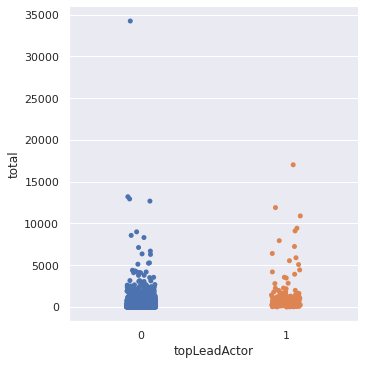

In [177]:
sns.catplot(x='topLeadActor', y='total', data=train);


In [178]:
# calculate Pearson's correlation
corr, _ = pearsonr(train['topLeadActor'], train['total'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.178


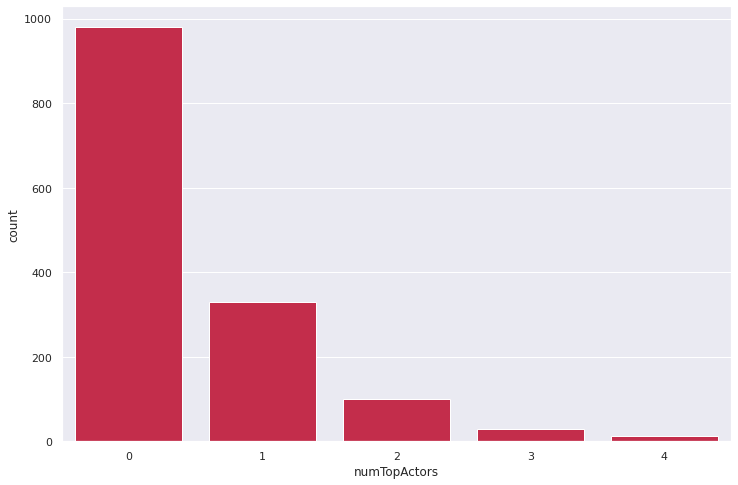

In [179]:
sns.set(rc={'figure.figsize':(12,8)})
sns.countplot(x=train.numTopActors, color='crimson')

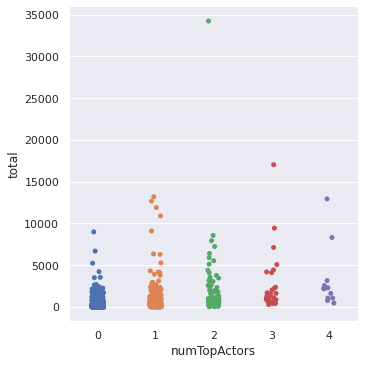

In [180]:
sns.catplot(x='numTopActors', y='total', data=train);


In [181]:
# calculate Pearson's correlation
corr, _ = pearsonr(train['numTopActors'], train['total'])
print('Pearsons correlation: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['numTopActors']), np.log1p((train['total'])))
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.351
Pearsons correlation: 0.461


Specific Crew Features by Revenue¶


In [183]:
train['directors'] = train['MovieDirectors'].apply(concomp)


In [184]:
train['directors']

0                 [Todd Haynes]
1       [Gilles Paquet-Brenner]
2                [Ericson Core]
3                  [Paul Soter]
4              [James DeMonaco]
                 ...           
1444                [Jon Lucas]
1445              [Woody Allen]
1446           [Barry Levinson]
1447        [Quentin Tarantino]
1448          [Nick Cassavetes]
Name: directors, Length: 1449, dtype: object

In [185]:
train['num_director'] = train['directors'].apply(lambda x: len(x))
train['num_director'].value_counts()

1    1449
Name: num_director, dtype: int64

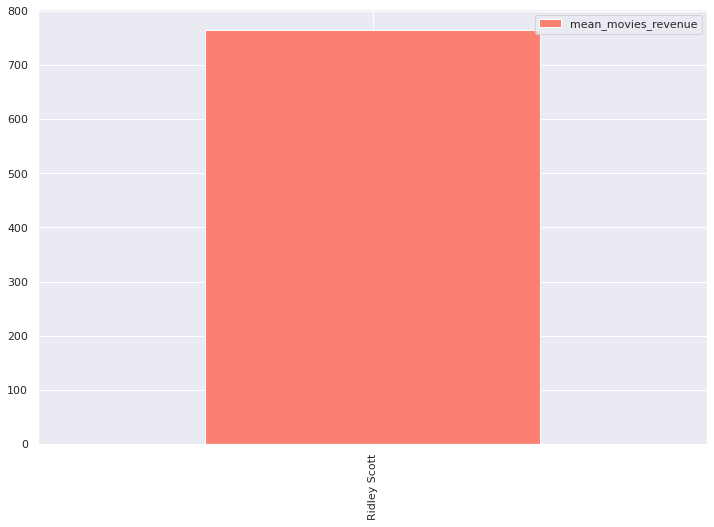

In [188]:

directorsDict = {}
for element in train[["total", "directors"]].values:

    for director in element[1]:
        if director not in directorsDict:
            directorsDict[director] = [element[0], 1]
        else:
            directorsDict[director][0] += element[0]
            directorsDict[director][1] += 1

directorsDict = {k: v for k, v in directorsDict.items() if v[1] >= 5}

for director in directorsDict:
    directorsDict[director][0] = directorsDict[director][0]/directorsDict[director][1]
    directorsDict[director] = directorsDict[director][0]

    
directors_train = pd.DataFrame.from_dict(directorsDict, orient='index', columns=["mean_movies_revenue"])
directors_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='salmon')

directors_train.columns = ["number_of_directors"]

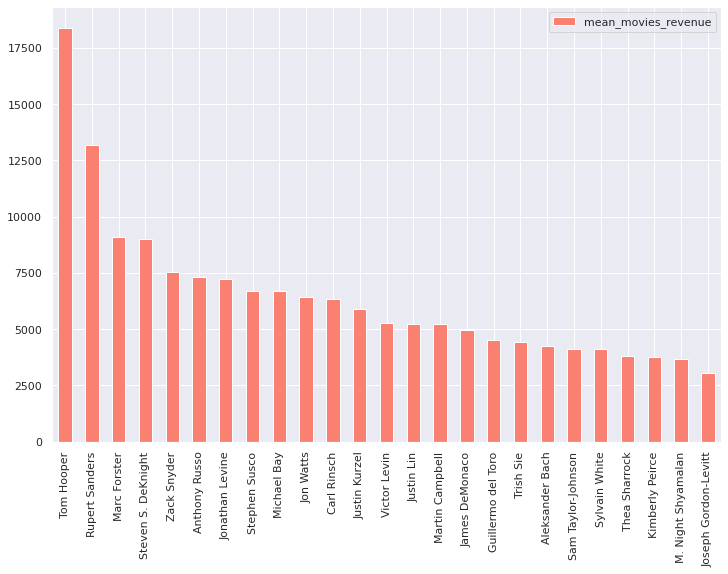

In [186]:
leadDirectorsDict = {}
for element in train[["total", "directors"]].values:
   # compare results when looking at x top directors in films vs whole cast 
    temp = 1
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in leadDirectorsDict:
            leadDirectorsDict[element[1][i]] = [element[0], 1]
        else:
            leadDirectorsDict[element[1][i]][0] += element[0]
            leadDirectorsDict[element[1][i]][1] += 1    

leadDirectorsDict = {k: v for k, v in leadDirectorsDict.items() if v[1] >= 1}

for director in leadDirectorsDict:
    leadDirectorsDict[director][0] = leadDirectorsDict[director][0]/leadDirectorsDict[director][1]
    leadDirectorsDict[director] = leadDirectorsDict[director][0]


    
    
directors_train = pd.DataFrame.from_dict(leadDirectorsDict, orient='index', columns=["mean_movies_revenue"])
directors_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='salmon')

In [189]:
# Sort both of our dicts
leadDirectorsDict = {k: v for k, v in sorted(leadDirectorsDict.items(), key=lambda item: item[1], reverse = True)}
directorsDict = {k: v for k, v in sorted(directorsDict.items(), key=lambda item: item[1], reverse = True)}


# function to check if lead role is a 'top director'
def checkLeadDirector(crew):
    if len(crew) < 1 or crew[0] not in list(leadDirectorsDict)[:25]:
        return 0
    else:
        return 1

def checkTopDirectors(crew):
    if len(crew) < 1:
        return 0
    count = 0
    for director in crew[:5]:
        if director in list(directorsDict)[:100]:
            count += 1
    return count

#Creating a feature for top LEAD directors
train['topLeadDirector'] = train['directors'].apply(lambda x: checkLeadDirector(x))

#Creating feature for number of top directors
train['numTopDirectors'] = train['directors'].apply(lambda x: checkTopDirectors(x))


print(train['topLeadDirector'].value_counts())
print()
print(train['numTopDirectors'].value_counts())

0    1411
1      38
Name: topLeadDirector, dtype: int64

0    1444
1       5
Name: numTopDirectors, dtype: int64
